In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import f_oneway

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene, shapiro
import scikit_posthocs as sp

import itertools
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [2]:
eval_to_system = {
    "SNF_short_coqui_base": "9_2",
    "SNF_long_coqui_base": "9_2",
    "GPT_long_coqui_base": "9_2",
    "SNF_short_coqui_srf": "7_5",
    "SNF_long_coqui_srf": "7_5",
    "GPT_long_coqui_srf": "7_5",
    "SNF_short_coqui_srf_finetuned": "7_6_SNF",
    "SNF_long_coqui_srf_finetuned": "7_6_SNF",
    "GPT_long_coqui_srf_finetuned": "7_6_SNF"
}

In [3]:
def load_dataframe(evaluator: int, long: bool = False) -> pd.DataFrame:
    """
    The last row has the average and median values, as such we need to drop them to have clean df's
    """
    eval_type = "long" if long else "snf short"
    df = pd.read_excel("HumanEvaluation.xlsx", sheet_name=f"Evaluator {evaluator} {eval_type}")
    df = df.iloc[:-2]
    
    df["evaluator"] = evaluator
    df["model"] = [eval_to_system[elem] for elem in df["system"]]
    return df

df_eval_g1_snf_short_e0 = load_dataframe(0, long=False)
df_eval_g1_snf_short_e3 = load_dataframe(3, long=False)
df_eval_g1_long_e0 = load_dataframe(0, long=True)
df_eval_g1_long_e3 = load_dataframe(3, long=True)

df_eval_g2_snf_short_e1 = load_dataframe(1, long=False)
df_eval_g2_snf_short_e4 = load_dataframe(4, long=False)
df_eval_g2_long_e1 = load_dataframe(1, long=True)
df_eval_g2_long_e4 = load_dataframe(4, long=True)

df_eval_g3_snf_short_e2 = load_dataframe(2, long=False)
df_eval_g3_snf_short_e5 = load_dataframe(5, long=False)
df_eval_g3_long_e2 = load_dataframe(2, long=True)
df_eval_g3_long_e5 = load_dataframe(5, long=True)

In [4]:
df_eval_g1_snf_short_e0.head()

,session_id,sample_id,orig_dialect,speaker_id,system,smos,cmos,intelligibility,text,evaluator,model
0,aaa96d65-b474-4be8-b536-c3c4367d45ba,1f4672c899346133ecfc8b73b3bda809447810a6427fcf...,GraubÃ¼nden,031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72,SNF_short_coqui_base,4.0,2.0,4.0,Und auch die hohen Lebenshaltungskosten trÃ¼be...,0,9_2
1,aaa96d65-b474-4be8-b536-c3c4367d45ba,de69bd12b304e8923568d078d45d04beca0dca5436a6f5...,Bern,d9b44aee-da3d-42c8-8ad1-d1029767f05a,SNF_short_coqui_base,3.0,-1.0,3.0,Sie zeigen die beiden EntfÃ¼hrten vor einem gr...,0,9_2
2,aaa96d65-b474-4be8-b536-c3c4367d45ba,de69bd12b304e8923568d078d45d04beca0dca5436a6f5...,Wallis,0b890339-031a-43ef-bc2e-5e8b5ac5e613,SNF_short_coqui_srf,1.5,-1.0,2.0,Sie zeigen die beiden EntfÃ¼hrten vor einem gr...,0,7_5
3,aaa96d65-b474-4be8-b536-c3c4367d45ba,1f4672c899346133ecfc8b73b3bda809447810a6427fcf...,Ostschweiz,831d404d-b189-42b6-8120-073c1f8af73c,SNF_short_coqui_srf_finetuned,4.0,0.0,5.0,Und auch die hohen Lebenshaltungskosten trÃ¼be...,0,7_6_SNF
4,aaa96d65-b474-4be8-b536-c3c4367d45ba,de69bd12b304e8923568d078d45d04beca0dca5436a6f5...,Bern,d9b44aee-da3d-42c8-8ad1-d1029767f05a,SNF_short_coqui_srf_finetuned,3.5,0.0,4.0,Sie zeigen die beiden EntfÃ¼hrten vor einem gr...,0,7_6_SNF


In [5]:
subset_1_snf_short = pd.concat([df_eval_g1_snf_short_e0, df_eval_g1_snf_short_e3], ignore_index=True)
subset_1_long = pd.concat([df_eval_g1_long_e0, df_eval_g1_long_e3], ignore_index=True)

subset_2_snf_short = pd.concat([df_eval_g2_snf_short_e1, df_eval_g2_snf_short_e4], ignore_index=True)
subset_2_long = pd.concat([df_eval_g2_long_e1, df_eval_g2_long_e4], ignore_index=True)

subset_3_snf_short = pd.concat([df_eval_g1_snf_short_e0, df_eval_g3_snf_short_e5], ignore_index=True)
subset_3_long = pd.concat([df_eval_g3_long_e2, df_eval_g3_long_e5], ignore_index=True)

complete_subset_1 = pd.concat([subset_1_snf_short, subset_1_long], ignore_index=True)
complete_subset_2 = pd.concat([subset_2_snf_short, subset_2_long], ignore_index=True)
complete_subset_3 = pd.concat([subset_3_snf_short, subset_3_long], ignore_index=True)

complete_snf_short = pd.concat([subset_1_snf_short, subset_2_snf_short, subset_3_snf_short], ignore_index=True)
complete_long = pd.concat([subset_1_long, subset_2_long, subset_3_long], ignore_index=True)

complete_model = pd.concat([complete_snf_short, complete_long], ignore_index=True)

# 1. Analyse on evaluator basis and system type

In [209]:
metrics = ['smos', 'cmos', 'intelligibility']
aggregations = ['mean', 'std']

In [51]:
def test_homogenity_normality(df, metric):
    # Test homogeneity of variance (Levene's test)
    stat, p = levene(*[df[df["model"] == model][metric] for model in df["model"].unique()])
    print(f"Levene's Test for Homogeneity of Variance: p={p:.4f}")
    levene_below_0_05 = p <= 0.05

    # Test normality for each group (Shapiro-Wilk test)
    shapiro_any_under_p = False
    for model in df["model"].unique():
        stat, p = shapiro(df[df["model"] == model][metric])
        print(f"Shapiro-Wilk Test for Normality ({model}): p={p:.4f}")
        if p <= 0.05:
            shapiro_any_under_p = True
    print(f"levene_below_0_05={levene_below_0_05} shapiro_any_under_p={shapiro_any_under_p}")
    return levene_below_0_05, shapiro_any_under_p


def perform_kruskal_or_anova(levene_below_0_05, shapiro_any_under_p, groups):
    if not levene_below_0_05 and not shapiro_any_under_p:
        f_stat, p_value = f_oneway(*groups)
        print(f"ANOVA Results: F={f_stat:.4f}, p={p_value:.4f}")
    else:
        f_stat, p_value = kruskal(*groups)
        print(f"kruskal Results: F={f_stat:.4f}, p={p_value:.4f}")
        # Print the results
    return f_stat, p_value

In [142]:
def group_by_system_and_evaluator(df: pd.DataFrame) -> pd.DataFrame:
    # One-liner
    # grouped = df.groupby(['system', 'evaluator'])[['smos', 'cmos', 'intelligibility']].agg(['mean', 'median'])
    
    # Group by 'Evaluator' and 'System'
    grouped = df.groupby(['system', 'evaluator'])

    # Aggregate with mean, median, and count (support)
    result = grouped[metrics].agg(aggregations)
    
    for metric in metrics:
        for aggr in aggregations:
            result[(metric, aggr)] = result[(metric, aggr)].round(2)
        
    result['support'] = grouped.size()
    # print(result.to_latex())
    return result

In [104]:
def group_by_system(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['system'])

    # Aggregate with mean, median, and count (support)
    result = grouped[metrics].agg(aggregations)
    
#     for metric in metrics:
        
#         levene_below_0_05, shapiro_any_under_p = test_homogenity_normality(df, metric)
        
#         # Separate the data into groups
#         group_a = df[df['model'] == '7_5'][metric]
#         group_b = df[df['model'] == '7_6_SNF'][metric]
#         group_c = df[df['model'] == '9_2'][metric]
#         groups = [group_a, group_b, group_c]
        
#         f_stat, p_value = perform_kruskal_or_anova(levene_below_0_05, shapiro_any_under_p, groups)
#         print(f"Metric: {metric}")
#         print(f"F-statistic: {f_stat}")
#         print(f"P-value: {p_value}")
        
#         if p_value <= 0.05:
#             print(f"Post-hoc analysis for {metric}:")
#             if not levene_below_0_05 and not shapiro_any_under_p:
#                 tukey = pairwise_tukeyhsd(df[metric], df['model'], alpha=0.05)
#                 print("Tukey results")
#                 print(tukey)
#                 print("\n")
#             else:
                
# #                 dunn = sp.posthoc_dunn(df, val_col=metric, group_col='model', p_adjust='bonferroni')
# #                 print("Dunn results")
# #                 print(dunn)
# #                 print("\n")
#                 pairwise_results = []
#                 comparisons = list(itertools.combinations(df['model'].unique(), 2))

#                 for model_a, model_b in comparisons:
#                     model_a_metric = df[df['model'] == model_a][metric]
#                     model_b_metric = df[df['model'] == model_b][metric]
#                     w_stat, p_wilcoxon = wilcoxon(model_a_metric, model_b_metric)
#                     pairwise_results.append((model_a, model_b, w_stat, p_wilcoxon))

#                 # Step 3: Apply Bonferroni Correction
#                 p_values = [res[3] for res in pairwise_results]  # Extract p-values
#                 _, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

#                 # Step 4: Print Results in Table Format
#                 df_results = pd.DataFrame(pairwise_results, columns=["Model A", "Model B", "Wilcoxon W", "Raw p-value"])
#                 df_results["Bonferroni p-value"] = p_corrected
#                 df_results["Significant? (p<0.0167)"] = df_results["Bonferroni p-value"] < 0.0167
    
#                 print(df_results.to_string(index=False))
        
    for metric in metrics:
        for aggr in aggregations:
            result[(metric, aggr)] = result[(metric, aggr)].round(2)
        
    result['support'] = grouped.size()
    
    return result

In [105]:
list(itertools.combinations(['7_5', '7_6_SNF', '9_2'], 2))

[('7_5', '7_6_SNF'), ('7_5', '9_2'), ('7_6_SNF', '9_2')]

In [137]:
def group_by_speaker(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['speaker_id','orig_dialect'])
    result = grouped[metrics].agg(aggregations)
    for metric in metrics:
        for aggr in aggregations:
            result[(metric, aggr)] = result[(metric, aggr)].round(2)
    result['support'] = grouped.size()
#     print(result.to_latex())
    
    return result

In [152]:
def group_by_dialect(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['model', 'orig_dialect'])
    result = grouped[metrics].agg(aggregations)
    for metric in metrics:
        for aggr in aggregations:
            result[(metric, aggr)] = result[(metric, aggr)].round(2)
    result['support'] = grouped.size()
    print(result.to_latex())
    
    return result

In [121]:
def group_by_model(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['model'])
    metrics = ['smos', 'cmos', 'intelligibility']
    # Aggregate with mean, median, and count (support)
    result = grouped[metrics].agg(aggregations)
    result['support'] = grouped.size()
    
#     for metric in metrics:
#         # Separate the data into groups
#         group_a = df[df['model'] == '7_5'][metric]
#         group_b = df[df['model'] == '7_6_SNF'][metric]
#         group_c = df[df['model'] == '9_2'][metric]
#         groups = [group_a, group_b, group_c]
        
#         levene_below_0_05, shapiro_any_under_p = test_homogenity_normality(df, metric)
        
#         f_stat, p_value = perform_kruskal_or_anova(levene_below_0_05, shapiro_any_under_p, groups)
#         print(f"Metric: {metric}")
#         print(f"F-statistic: {f_stat}")
#         print(f"P-value: {p_value}")
        
        
#         if p_value <= 0.05:
#             print(f"Post-hoc analysis for {metric}:")
#             if not levene_below_0_05 and not shapiro_any_under_p:                
#                 tukey = pairwise_tukeyhsd(df[metric], df['model'], alpha=0.05)
#                 print("Tukey results")
#                 print(tukey)
#                 print("\n")
#             else:
# #                 dunn = sp.posthoc_dunn(df, val_col=metric, group_col='model', p_adjust='bonferroni')
# #                 print("Dunn results")
# #                 print(dunn)
# #                 print("\n")
#                     # Step 2: Pairwise Wilcoxon signed-rank tests
#                 pairwise_results = []
#                 comparisons = list(itertools.combinations(df['model'].unique(), 2))

#                 for model_a, model_b in comparisons:
#                     model_a_metric = df[df['model'] == model_a][metric]
#                     model_b_metric = df[df['model'] == model_b][metric]
#                     w_stat, p_wilcoxon = wilcoxon(model_a_metric, model_b_metric)
#                     pairwise_results.append((model_a, model_b, w_stat, p_wilcoxon))

#                 # Step 3: Apply Bonferroni Correction
#                 p_values = [res[3] for res in pairwise_results]  # Extract p-values
#                 _, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

#                 # Step 4: Print Results in Table Format
#                 df_results = pd.DataFrame(pairwise_results, columns=["Model A", "Model B", "Wilcoxon W", "Raw p-value"])
#                 df_results["Bonferroni p-value"] = p_corrected
#                 df_results["Significant? (p<0.0167)"] = df_results["Bonferroni p-value"] < 0.0167

#                 print(df_results.to_string(index=False))
            
    for metric in metrics:
        for aggr in aggregations:
            result[(metric, aggr)] = result[(metric, aggr)].round(2)
    print(result.to_latex())
    return result

## 1.1 Aggregated by System and Evaluator

In [21]:
group_by_system_and_evaluator(subset_1_snf_short)

smos        cmos        \
                                         mean   std  mean   std   
system                        evaluator                           
SNF_short_coqui_base          0          3.43  0.43  0.00  0.68   
                              3          3.11  0.86 -0.86  0.66   
SNF_short_coqui_srf           0          3.61  0.88 -0.21  0.43   
                              3          2.79  1.14 -1.00  1.36   
SNF_short_coqui_srf_finetuned 0          3.54  0.60  0.07  0.27   
                              3          3.71  0.87 -0.64  0.84   

                                        intelligibility       support  
                                                   mean   std          
system                        evaluator                                
SNF_short_coqui_base          0                    4.64  0.63      14  
                              3                    4.21  1.05      14  
SNF_short_coqui_srf           0                    3.79  1.31      14  
                              3                    3.29  1.73      14  
SNF_short_coqui_srf_finetuned 0                    4.79  0.43      14  
                              3                    4.50  0.85      14

In [22]:
group_by_system_and_evaluator(subset_2_snf_short)

smos        cmos        \
                                         mean   std  mean   std   
system                        evaluator                           
SNF_short_coqui_base          1          3.46  0.87 -1.00  0.96   
                              4          3.21  0.43 -1.21  0.89   
SNF_short_coqui_srf           1          3.71  1.27 -0.21  0.43   
                              4          3.46  0.95 -0.71  0.99   
SNF_short_coqui_srf_finetuned 1          3.57  0.76 -0.71  0.73   
                              4          3.14  0.53 -0.50  0.52   

                                        intelligibility       support  
                                                   mean   std          
system                        evaluator                                
SNF_short_coqui_base          1                    3.86  0.77      14  
                              4                    4.21  1.19      14  
SNF_short_coqui_srf           1                    4.71  0.47      14  
                              4                    4.21  0.89      14  
SNF_short_coqui_srf_finetuned 1                    4.43  0.65      14  
                              4                    4.86  0.36      14

In [23]:
group_by_system_and_evaluator(subset_3_snf_short)

smos        cmos        \
                                         mean   std  mean   std   
system                        evaluator                           
SNF_short_coqui_base          0          3.43  0.43  0.00  0.68   
                              5          1.96  0.77 -1.71  0.73   
SNF_short_coqui_srf           0          3.61  0.88 -0.21  0.43   
                              5          3.18  0.99 -0.93  0.73   
SNF_short_coqui_srf_finetuned 0          3.54  0.60  0.07  0.27   
                              5          1.96  0.69 -1.43  1.09   

                                        intelligibility       support  
                                                   mean   std          
system                        evaluator                                
SNF_short_coqui_base          0                    4.64  0.63      14  
                              5                    3.43  0.76      14  
SNF_short_coqui_srf           0                    3.79  1.31      14  
                              5                    3.29  1.27      14  
SNF_short_coqui_srf_finetuned 0                    4.79  0.43      14  
                              5                    3.71  0.61      14

In [24]:
group_by_system_and_evaluator(subset_1_long)

smos        cmos        \
                                        mean   std  mean   std   
system                       evaluator                           
GPT_long_coqui_base          0          3.29  0.27 -0.43  0.53   
                             3          2.21  0.86 -1.71  0.49   
GPT_long_coqui_srf           0          4.14  0.24 -0.43  0.53   
                             3          3.50  0.58 -0.43  0.53   
GPT_long_coqui_srf_finetuned 0          3.86  0.80 -0.29  0.49   
                             3          2.57  0.67 -0.29  0.49   
SNF_long_coqui_base          0          3.43  0.35 -0.71  0.49   
                             3          2.50  0.91 -0.86  0.90   
SNF_long_coqui_srf           0          4.36  0.56 -0.14  0.38   
                             3          4.21  0.57 -0.43  0.53   
SNF_long_coqui_srf_finetuned 0          3.43  0.45 -0.29  0.49   
                             3          2.79  1.07 -1.00  0.82   

                                       intelligibility       support  
                                                  mean   std          
system                       evaluator                                
GPT_long_coqui_base          0                    4.14  0.90       7  
                             3                    3.29  0.76       7  
GPT_long_coqui_srf           0                    4.57  0.79       7  
                             3                    4.00  1.00       7  
GPT_long_coqui_srf_finetuned 0                    4.86  0.38       7  
                             3                    4.14  0.90       7  
SNF_long_coqui_base          0                    4.86  0.38       7  
                             3                    4.29  0.76       7  
SNF_long_coqui_srf           0                    4.57  0.79       7  
                             3                    4.14  0.90       7  
SNF_long_coqui_srf_finetuned 0                    4.43  1.13       7  
                             3                    4.43  0.79       7

In [25]:
group_by_system_and_evaluator(subset_2_long)

smos        cmos        \
                                        mean   std  mean   std   
system                       evaluator                           
GPT_long_coqui_base          1          3.86  0.56 -0.86  0.69   
                             4          3.93  0.35 -0.43  0.53   
GPT_long_coqui_srf           1          4.29  0.91 -0.29  1.25   
                             4          4.14  0.24  0.00  1.00   
GPT_long_coqui_srf_finetuned 1          3.93  0.53 -0.43  0.53   
                             4          4.00  0.29 -0.43  0.53   
SNF_long_coqui_base          1          3.07  0.98 -1.14  0.69   
                             4          3.64  0.24 -0.43  0.53   
SNF_long_coqui_srf           1          4.29  0.27  0.00  0.00   
                             4          4.21  0.39 -0.29  0.49   
SNF_long_coqui_srf_finetuned 1          3.29  0.95 -1.29  0.76   
                             4          3.79  0.27 -0.29  0.49   

                                       intelligibility       support  
                                                  mean   std          
system                       evaluator                                
GPT_long_coqui_base          1                    3.86  0.69       7  
                             4                    3.71  0.49       7  
GPT_long_coqui_srf           1                    4.29  0.76       7  
                             4                    4.14  0.90       7  
GPT_long_coqui_srf_finetuned 1                    4.14  0.38       7  
                             4                    4.14  0.69       7  
SNF_long_coqui_base          1                    3.71  0.76       7  
                             4                    4.29  1.11       7  
SNF_long_coqui_srf           1                    4.57  0.53       7  
                             4                    3.86  1.07       7  
SNF_long_coqui_srf_finetuned 1                    4.14  0.69       7  
                             4                    4.57  0.53       7

In [26]:
group_by_system_and_evaluator(subset_3_long)

smos        cmos        \
                                        mean   std  mean   std   
system                       evaluator                           
GPT_long_coqui_base          2          2.79  0.81 -0.71  0.76   
                             5          2.21  0.95 -1.57  0.98   
GPT_long_coqui_srf           2          3.57  1.06 -0.29  0.95   
                             5          2.50  0.96 -0.14  0.69   
GPT_long_coqui_srf_finetuned 2          3.00  0.91 -0.71  0.49   
                             5          2.29  0.76 -1.29  0.76   
SNF_long_coqui_base          2          2.50  1.04 -0.71  0.76   
                             5          2.29  0.81 -1.71  0.76   
SNF_long_coqui_srf           2          3.64  0.56 -0.57  0.98   
                             5          2.86  0.99 -0.43  0.98   
SNF_long_coqui_srf_finetuned 2          2.86  0.48 -0.43  0.53   
                             5          2.07  0.84 -1.57  0.98   

                                       intelligibility       support  
                                                  mean   std          
system                       evaluator                                
GPT_long_coqui_base          2                    4.00  1.00       7  
                             5                    3.43  0.53       7  
GPT_long_coqui_srf           2                    3.86  1.46       7  
                             5                    3.43  0.79       7  
GPT_long_coqui_srf_finetuned 2                    4.29  0.49       7  
                             5                    3.71  0.76       7  
SNF_long_coqui_base          2                    4.71  0.76       7  
                             5                    3.29  0.49       7  
SNF_long_coqui_srf           2                    4.14  0.69       7  
                             5                    3.71  0.49       7  
SNF_long_coqui_srf_finetuned 2                    4.71  0.49       7  
                             5                    3.86  0.38       7

## 1.2 Aggregated by system

In [93]:
group_by_system(subset_1_snf_short)

Levene's Test for Homogeneity of Variance: p=0.1197
Shapiro-Wilk Test for Normality (9_2): p=0.0015
Shapiro-Wilk Test for Normality (7_5): p=0.0383
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0153
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=3.5990, p=0.1654
Metric: smos
F-statistic: 3.599010768278153
P-value: 0.16538066789658887
Levene's Test for Homogeneity of Variance: p=0.3061
Shapiro-Wilk Test for Normality (9_2): p=0.0001
Shapiro-Wilk Test for Normality (7_5): p=0.0004
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=1.3958, p=0.4976
Metric: cmos
F-statistic: 1.3958064492710527
P-value: 0.4976276239965458
Levene's Test for Homogeneity of Variance: p=0.0001
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0001
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=True shapiro_any_under_p=True
kruskal Results: F=10.0157, p=0.0067

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


smos        cmos       intelligibility        \
                               mean   std  mean   std            mean   std   
system                                                                        
SNF_short_coqui_base           3.27  0.69 -0.43  0.79            4.43  0.88   
SNF_short_coqui_srf            3.20  1.08 -0.61  1.07            3.54  1.53   
SNF_short_coqui_srf_finetuned  3.62  0.74 -0.29  0.71            4.64  0.68   

                              support  
                                       
system                                 
SNF_short_coqui_base               28  
SNF_short_coqui_srf                28  
SNF_short_coqui_srf_finetuned      28

In [28]:
group_by_system(subset_2_snf_short)

smos        cmos       intelligibility        \
                               mean   std  mean   std            mean   std   
system                                                                        
SNF_short_coqui_base           3.34  0.68 -1.11  0.92            4.04  1.00   
SNF_short_coqui_srf            3.59  1.11 -0.46  0.79            4.46  0.74   
SNF_short_coqui_srf_finetuned  3.36  0.68 -0.61  0.63            4.64  0.56   

                              support  
                                       
system                                 
SNF_short_coqui_base               28  
SNF_short_coqui_srf                28  
SNF_short_coqui_srf_finetuned      28

In [29]:
group_by_system(subset_3_snf_short)

smos        cmos       intelligibility        \
                               mean   std  mean   std            mean   std   
system                                                                        
SNF_short_coqui_base           2.70  0.97 -0.86  1.11            4.04  0.92   
SNF_short_coqui_srf            3.39  0.95 -0.57  0.69            3.54  1.29   
SNF_short_coqui_srf_finetuned  2.75  1.02 -0.68  1.09            4.25  0.75   

                              support  
                                       
system                                 
SNF_short_coqui_base               28  
SNF_short_coqui_srf                28  
SNF_short_coqui_srf_finetuned      28

In [77]:
group_by_system(complete_snf_short)

Levene's Test for Homogeneity of Variance: p=0.0975
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0004
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=6.7734, p=0.0338
Metric: smos
F-statistic: 6.773376202029507
P-value: 0.0338205017064081
Post-hoc analysis for smos:
Dunn results
              7_5   7_6_SNF       9_2
7_5      1.000000  0.421503  0.028413
7_6_SNF  0.421503  1.000000  0.787327
9_2      0.028413  0.787327  1.000000


Levene's Test for Homogeneity of Variance: p=0.4960
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=6.9722, p=0.0306
Metric: cmos
F-statistic: 6.972245150470078
P-value: 0.030619366586459272
Post-hoc analysis for cmos:
Dunn results
              7_5   7_6_SNF       9_2
7_5      1

smos        cmos       intelligibility        \
                               mean   std  mean   std            mean   std   
system                                                                        
SNF_short_coqui_base           3.10  0.83 -0.80  0.98            4.17  0.94   
SNF_short_coqui_srf            3.39  1.05 -0.55  0.86            3.85  1.29   
SNF_short_coqui_srf_finetuned  3.24  0.90 -0.52  0.84            4.51  0.69   

                              support  
                                       
system                                 
SNF_short_coqui_base               84  
SNF_short_coqui_srf                84  
SNF_short_coqui_srf_finetuned      84

In [32]:
group_by_system(subset_1_long)

smos        cmos       intelligibility        \
                              mean   std  mean   std            mean   std   
system                                                                       
GPT_long_coqui_base           2.75  0.83 -1.07  0.83            3.71  0.91   
GPT_long_coqui_srf            3.82  0.54 -0.43  0.51            4.29  0.91   
GPT_long_coqui_srf_finetuned  3.21  0.97 -0.29  0.47            4.50  0.76   
SNF_long_coqui_base           2.96  0.82 -0.79  0.70            4.57  0.65   
SNF_long_coqui_srf            4.29  0.54 -0.29  0.47            4.36  0.84   
SNF_long_coqui_srf_finetuned  3.11  0.86 -0.64  0.74            4.43  0.94   

                             support  
                                      
system                                
GPT_long_coqui_base               14  
GPT_long_coqui_srf                14  
GPT_long_coqui_srf_finetuned      14  
SNF_long_coqui_base               14  
SNF_long_coqui_srf                14  
SNF_long_coqui_srf_finetuned      14

In [33]:
group_by_system(subset_2_long)

smos        cmos       intelligibility        \
                              mean   std  mean   std            mean   std   
system                                                                       
GPT_long_coqui_base           3.89  0.45 -0.64  0.63            3.79  0.58   
GPT_long_coqui_srf            4.21  0.64 -0.14  1.10            4.21  0.80   
GPT_long_coqui_srf_finetuned  3.96  0.41 -0.43  0.51            4.14  0.53   
SNF_long_coqui_base           3.36  0.74 -0.79  0.70            4.00  0.96   
SNF_long_coqui_srf            4.25  0.33 -0.14  0.36            4.21  0.89   
SNF_long_coqui_srf_finetuned  3.54  0.72 -0.79  0.80            4.36  0.63   

                             support  
                                      
system                                
GPT_long_coqui_base               14  
GPT_long_coqui_srf                14  
GPT_long_coqui_srf_finetuned      14  
SNF_long_coqui_base               14  
SNF_long_coqui_srf                14  
SNF_long_coqui_srf_finetuned      14

In [34]:
group_by_system(subset_3_long)

smos        cmos       intelligibility        \
                              mean   std  mean   std            mean   std   
system                                                                       
GPT_long_coqui_base           2.50  0.90 -1.14  0.95            3.71  0.83   
GPT_long_coqui_srf            3.04  1.12 -0.21  0.80            3.64  1.15   
GPT_long_coqui_srf_finetuned  2.64  0.89 -1.00  0.68            4.00  0.68   
SNF_long_coqui_base           2.39  0.90 -1.21  0.89            4.00  0.96   
SNF_long_coqui_srf            3.25  0.87 -0.50  0.94            3.93  0.62   
SNF_long_coqui_srf_finetuned  2.46  0.77 -1.00  0.96            4.29  0.61   

                             support  
                                      
system                                
GPT_long_coqui_base               14  
GPT_long_coqui_srf                14  
GPT_long_coqui_srf_finetuned      14  
SNF_long_coqui_base               14  
SNF_long_coqui_srf                14  
SNF_long_coqui_srf_finetuned      14

In [53]:
group_by_system(complete_long)

Levene's Test for Homogeneity of Variance: p=0.1556
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0007
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=40.7534, p=0.0000
Metric: smos
F-statistic: 40.75336082978023
P-value: 1.4142302951306304e-09
Post-hoc analysis for smos:
Tukey results
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
    7_5 7_6_SNF  -0.6548    0.0 -0.9832 -0.3263   True
    7_5     9_2  -0.8333    0.0 -1.1617 -0.5049   True
7_6_SNF     9_2  -0.1786 0.4066  -0.507  0.1498  False
------------------------------------------------------


Levene's Test for Homogeneity of Variance: p=0.1828
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_be

smos        cmos       intelligibility        \
                              mean   std  mean   std            mean   std   
system                                                                       
GPT_long_coqui_base           3.05  0.96 -0.95  0.82            3.74  0.77   
GPT_long_coqui_srf            3.69  0.93 -0.26  0.83            4.05  0.99   
GPT_long_coqui_srf_finetuned  3.27  0.95 -0.57  0.63            4.21  0.68   
SNF_long_coqui_base           2.90  0.90 -0.93  0.78            4.19  0.89   
SNF_long_coqui_srf            3.93  0.78 -0.31  0.64            4.17  0.79   
SNF_long_coqui_srf_finetuned  3.04  0.89 -0.81  0.83            4.36  0.73   

                             support  
                                      
system                                
GPT_long_coqui_base               42  
GPT_long_coqui_srf                42  
GPT_long_coqui_srf_finetuned      42  
SNF_long_coqui_base               42  
SNF_long_coqui_srf                42  
SNF_long_coqui_srf_finetuned      42

## 1.3 Group by model

### 1.3.1 SNF Short

In [103]:
group_by_model(subset_1_snf_short)

Levene's Test for Homogeneity of Variance: p=0.1197
Shapiro-Wilk Test for Normality (9_2): p=0.0015
Shapiro-Wilk Test for Normality (7_5): p=0.0383
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0153
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=3.5990, p=0.1654
Metric: smos
F-statistic: 3.599010768278153
P-value: 0.16538066789658887
Levene's Test for Homogeneity of Variance: p=0.3061
Shapiro-Wilk Test for Normality (9_2): p=0.0001
Shapiro-Wilk Test for Normality (7_5): p=0.0004
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=1.3958, p=0.4976
Metric: cmos
F-statistic: 1.3958064492710527
P-value: 0.4976276239965458
Levene's Test for Homogeneity of Variance: p=0.0001
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0001
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=True shapiro_any_under_p=True
kruskal Results: F=10.0157, p=0.0067

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2524631398.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.20  1.08 -0.61  1.07            3.54  1.53      28
7_6_SNF  3.62  0.74 -0.29  0.71            4.64  0.68      28
9_2      3.27  0.69 -0.43  0.79            4.43  0.88      28

In [99]:
group_by_model(subset_2_snf_short)

Levene's Test for Homogeneity of Variance: p=0.1238
Shapiro-Wilk Test for Normality (9_2): p=0.0470
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0859
Shapiro-Wilk Test for Normality (7_5): p=0.0009
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=4.4007, p=0.1108
Metric: smos
F-statistic: 4.400728803228392
P-value: 0.11076278886836972
Levene's Test for Homogeneity of Variance: p=0.8947
Shapiro-Wilk Test for Normality (9_2): p=0.0088
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=9.6897, p=0.0079
Metric: cmos
F-statistic: 9.689683869283288
P-value: 0.007868861151049004
Post-hoc analysis for cmos:
Model A Model B  Wilcoxon W  Raw p-value  Bonferroni p-value  Significant? (p<0.0167)
    9_2 7_6_SNF        44.0     0.032590            0.097771                    False
    9_2     7_5        67.5     0.014743            0.044229                    Fal

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2524631398.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.59  1.11 -0.46  0.79            4.46  0.74      28
7_6_SNF  3.36  0.68 -0.61  0.63            4.64  0.56      28
9_2      3.34  0.68 -1.11  0.92            4.04  1.00      28

In [101]:
group_by_model(subset_3_snf_short)

Levene's Test for Homogeneity of Variance: p=0.7763
Shapiro-Wilk Test for Normality (9_2): p=0.0127
Shapiro-Wilk Test for Normality (7_5): p=0.0377
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.1167
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=8.3407, p=0.0154
Metric: smos
F-statistic: 8.340718852777474
P-value: 0.015446707171853882
Post-hoc analysis for smos:
Model A Model B  Wilcoxon W  Raw p-value  Bonferroni p-value  Significant? (p<0.0167)
    9_2     7_5        42.0     0.003232            0.009695                     True
    9_2 7_6_SNF        81.0     0.353643            1.000000                    False
    7_5 7_6_SNF        71.5     0.013750            0.041249                    False
HALLLLLLo
Levene's Test for Homogeneity of Variance: p=0.4309
Shapiro-Wilk Test for Normality (9_2): p=0.0081
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Re

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2524631398.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.39  0.95 -0.57  0.69            3.54  1.29      28
7_6_SNF  2.75  1.02 -0.68  1.09            4.25  0.75      28
9_2      2.70  0.97 -0.86  1.11            4.04  0.92      28

In [88]:
group_by_model(complete_snf_short)

Levene's Test for Homogeneity of Variance: p=0.0975
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0004
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=6.7734, p=0.0338
Metric: smos
F-statistic: 6.773376202029507
P-value: 0.0338205017064081
Post-hoc analysis for smos:
Model A Model B  Wilcoxon W  Raw p-value  Bonferroni p-value  Significant? (p<0.0167)
    9_2     7_5       750.0     0.021793            0.065379                    False
    9_2 7_6_SNF       826.0     0.142954            0.428863                    False
    7_5 7_6_SNF      1243.5     0.252746            0.758239                    False
Levene's Test for Homogeneity of Variance: p=0.4960
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=6.9

C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2937426026.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.39  1.05 -0.55  0.86            3.85  1.29      84
7_6_SNF  3.24  0.90 -0.52  0.84            4.51  0.69      84
9_2      3.10  0.83 -0.80  0.98            4.17  0.94      84

## 1.3.2 Long

In [98]:
group_by_model(subset_1_long)

Levene's Test for Homogeneity of Variance: p=0.2189
Shapiro-Wilk Test for Normality (9_2): p=0.0009
Shapiro-Wilk Test for Normality (7_5): p=0.0325
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.1582
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=28.6164, p=0.0000
Metric: smos
F-statistic: 28.61638462430063
P-value: 6.109856817643407e-07
Post-hoc analysis for smos:
Model A Model B  Wilcoxon W  Raw p-value  Bonferroni p-value  Significant? (p<0.0167)
    9_2     7_5         3.0     0.000010            0.000031                     True
    9_2 7_6_SNF        73.5     0.078970            0.236911                    False
    7_5 7_6_SNF        29.5     0.000501            0.001503                     True
HALLLLLLo
Levene's Test for Homogeneity of Variance: p=0.3466
Shapiro-Wilk Test for Normality (9_2): p=0.0002
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2524631398.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      4.05  0.58 -0.36  0.49            4.32  0.86      28
7_6_SNF  3.16  0.90 -0.46  0.64            4.46  0.84      28
9_2      2.86  0.81 -0.93  0.77            4.14  0.89      28

In [100]:
group_by_model(subset_2_long)

Levene's Test for Homogeneity of Variance: p=0.7545
Shapiro-Wilk Test for Normality (9_2): p=0.0001
Shapiro-Wilk Test for Normality (7_5): p=0.0002
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=19.7158, p=0.0001
Metric: smos
F-statistic: 19.715813641581796
P-value: 5.2331774895681134e-05
Post-hoc analysis for smos:
Model A Model B  Wilcoxon W  Raw p-value  Bonferroni p-value  Significant? (p<0.0167)
    9_2     7_5        32.0     0.000511            0.001534                     True
    9_2 7_6_SNF        53.5     0.243782            0.731347                    False
    7_5 7_6_SNF         9.5     0.003612            0.010837                     True
HALLLLLLo
Levene's Test for Homogeneity of Variance: p=0.4471
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_below_0_05=False shapiro_any_under_p=True
kruska

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2524631398.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      4.23  0.50 -0.14  0.80            4.21  0.83      28
7_6_SNF  3.75  0.62 -0.61  0.69            4.25  0.59      28
9_2      3.62  0.66 -0.71  0.66            3.89  0.79      28

In [102]:
group_by_model(subset_3_long)

Levene's Test for Homogeneity of Variance: p=0.6562
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.1629
Shapiro-Wilk Test for Normality (7_5): p=0.0439
Shapiro-Wilk Test for Normality (9_2): p=0.0024
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=9.0314, p=0.0109
Metric: smos
F-statistic: 9.031448645901769
P-value: 0.010935681292526771
Post-hoc analysis for smos:
Model A Model B  Wilcoxon W  Raw p-value  Bonferroni p-value  Significant? (p<0.0167)
7_6_SNF     7_5        59.0     0.008577            0.025732                    False
7_6_SNF     9_2       107.5     0.533866            1.000000                    False
    7_5     9_2        62.0     0.006383            0.019148                    False
HALLLLLLo
Levene's Test for Homogeneity of Variance: p=0.5289
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0010
Shapiro-Wilk Test for Normality (7_5): p=0.0026
Shapiro-Wilk Test for Normality (9_2): p=0.0006
levene_below_0_05=False shapiro_any_under_p=True
kruskal Re

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\2524631398.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.14  0.99 -0.36  0.87            3.79  0.92      28
7_6_SNF  2.55  0.82 -1.00  0.82            4.14  0.65      28
9_2      2.45  0.89 -1.18  0.90            3.86  0.89      28

In [61]:
group_by_model(complete_long)

Levene's Test for Homogeneity of Variance: p=0.1556
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0007
levene_below_0_05=False shapiro_any_under_p=True
kruskal Results: F=40.7534, p=0.0000
Metric: smos
F-statistic: 40.75336082978023
P-value: 1.4142302951306304e-09
Post-hoc analysis for smos:
Tukey results
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
    7_5 7_6_SNF  -0.6548    0.0 -0.9832 -0.3263   True
    7_5     9_2  -0.8333    0.0 -1.1617 -0.5049   True
7_6_SNF     9_2  -0.1786 0.4066  -0.507  0.1498  False
------------------------------------------------------


Levene's Test for Homogeneity of Variance: p=0.1828
Shapiro-Wilk Test for Normality (9_2): p=0.0000
Shapiro-Wilk Test for Normality (7_5): p=0.0000
Shapiro-Wilk Test for Normality (7_6_SNF): p=0.0000
levene_be

C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\1272435295.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.81  0.86 -0.29  0.74            4.11  0.89      84
7_6_SNF  3.15  0.92 -0.69  0.74            4.29  0.70      84
9_2      2.98  0.92 -0.94  0.80            3.96  0.86      84

## 1.4 Overall

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{smos} & \multicolumn{2}{l}{cmos} & \multicolumn{2}{l}{intelligibility} & support \\
{} &  mean &   std &  mean &   std &            mean & \multicolumn{2}{l}{std} \\
model   &       &       &       &       &                 &       &         \\
\midrule
7\_5     &  3.60 &  0.98 & -0.42 &  0.81 &            3.98 &  1.12 &     168 \\
7\_6\_SNF &  3.20 &  0.91 & -0.61 &  0.80 &            4.40 &  0.70 &     168 \\
9\_2     &  3.04 &  0.88 & -0.87 &  0.89 &            4.07 &  0.90 &     168 \\
\bottomrule
\end{tabular}



C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\247649736.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.60  0.98 -0.42  0.81            3.98  1.12     168
7_6_SNF  3.20  0.91 -0.61  0.80            4.40  0.70     168
9_2      3.04  0.88 -0.87  0.89            4.07  0.90     168

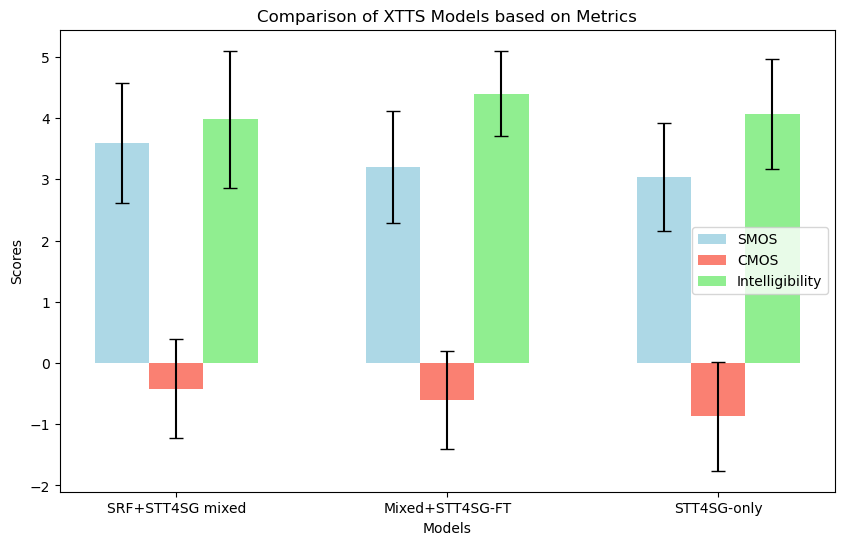

In [207]:
import numpy as np
res = group_by_model(complete_model)
# Model names
models = ['SRF+STT4SG mixed', 'Mixed+STT4SG-FT', 'STT4SG-only']

# Metrics means and std deviations
smos_means = res["smos", "mean"]
smos_std = res["smos", "std"]

cmos_means = res["cmos", "mean"]
cmos_std = res["cmos", "std"]

intelligibility_means = res["intelligibility", "mean"]
intelligibility_std = res["intelligibility", "std"]

# Creating the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.2
index = np.arange(len(models))

# Plotting bars for each metric
bar1 = ax.bar(index - bar_width, smos_means, bar_width, yerr=smos_std, label='SMOS', capsize=5, color='lightblue')
bar2 = ax.bar(index, cmos_means, bar_width, yerr=cmos_std, label='CMOS', capsize=5, color='salmon')
bar3 = ax.bar(index + bar_width, intelligibility_means, bar_width, yerr=intelligibility_std, label='Intelligibility', capsize=5, color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of XTTS Models based on Metrics')
ax.set_xticks(index)
ax.set_xticklabels(models,)
ax.legend()

res

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{smos} & \multicolumn{2}{l}{cmos} & \multicolumn{2}{l}{intelligibility} & support \\
{} &  mean &   std &  mean &   std &            mean & \multicolumn{2}{l}{std} \\
model   &       &       &       &       &                 &       &         \\
\midrule
7\_5     &  3.39 &  1.05 & -0.55 &  0.86 &            3.85 &  1.29 &      84 \\
7\_6\_SNF &  3.24 &  0.90 & -0.52 &  0.84 &            4.51 &  0.69 &      84 \\
9\_2     &  3.10 &  0.83 & -0.80 &  0.98 &            4.17 &  0.94 &      84 \\
\bottomrule
\end{tabular}



C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\247649736.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.39  1.05 -0.55  0.86            3.85  1.29      84
7_6_SNF  3.24  0.90 -0.52  0.84            4.51  0.69      84
9_2      3.10  0.83 -0.80  0.98            4.17  0.94      84

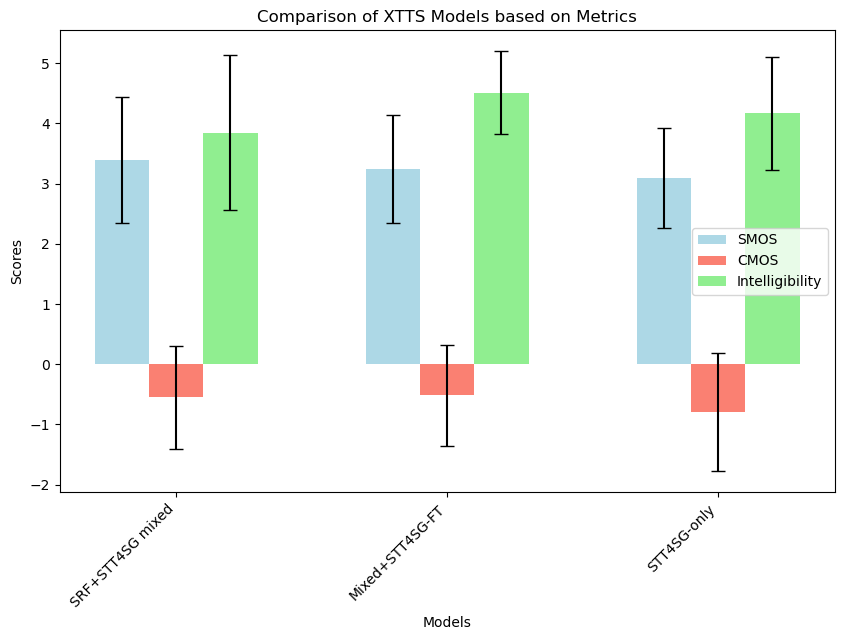

In [123]:
res = group_by_model(complete_snf_short)
# Model names
models = ['SRF+STT4SG mixed', 'Mixed+STT4SG-FT', 'STT4SG-only']

# Metrics means and std deviations
smos_means = res["smos", "mean"]
smos_std = res["smos", "std"]

cmos_means = res["cmos", "mean"]
cmos_std = res["cmos", "std"]

intelligibility_means = res["intelligibility", "mean"]
intelligibility_std = res["intelligibility", "std"]

# Creating the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.2
index = np.arange(len(models))

# Plotting bars for each metric
bar1 = ax.bar(index - bar_width, smos_means, bar_width, yerr=smos_std, label='SMOS', capsize=5, color='lightblue')
bar2 = ax.bar(index, cmos_means, bar_width, yerr=cmos_std, label='CMOS', capsize=5, color='salmon')
bar3 = ax.bar(index + bar_width, intelligibility_means, bar_width, yerr=intelligibility_std, label='Intelligibility', capsize=5, color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of XTTS Models based on Metrics')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

res

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{smos} & \multicolumn{2}{l}{cmos} & \multicolumn{2}{l}{intelligibility} & support \\
{} &  mean &   std &  mean &   std &            mean & \multicolumn{2}{l}{std} \\
model   &       &       &       &       &                 &       &         \\
\midrule
7\_5     &  3.81 &  0.86 & -0.29 &  0.74 &            4.11 &  0.89 &      84 \\
7\_6\_SNF &  3.15 &  0.92 & -0.69 &  0.74 &            4.29 &  0.70 &      84 \\
9\_2     &  2.98 &  0.92 & -0.94 &  0.80 &            3.96 &  0.86 &      84 \\
\bottomrule
\end{tabular}



C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\247649736.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


smos        cmos       intelligibility       support
         mean   std  mean   std            mean   std        
model                                                        
7_5      3.81  0.86 -0.29  0.74            4.11  0.89      84
7_6_SNF  3.15  0.92 -0.69  0.74            4.29  0.70      84
9_2      2.98  0.92 -0.94  0.80            3.96  0.86      84

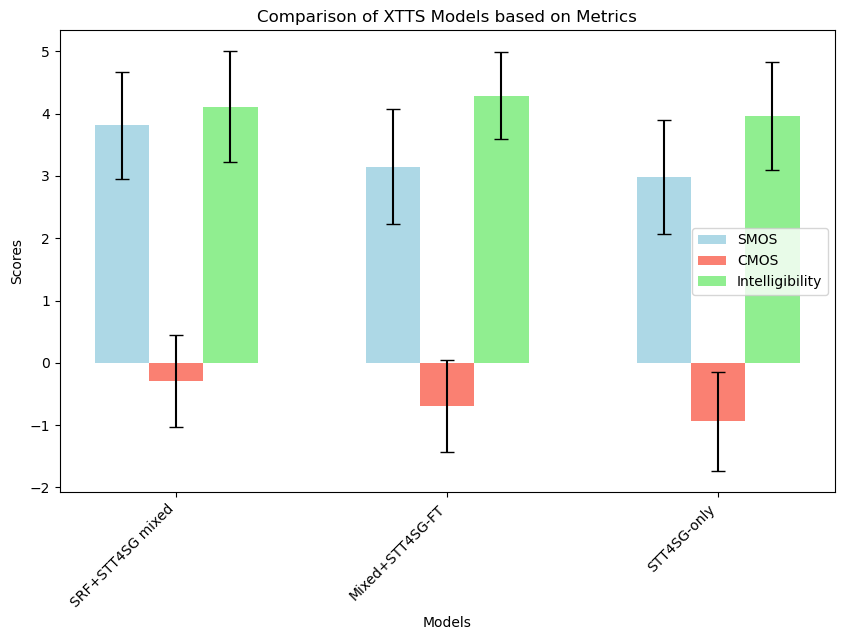

In [124]:
res = group_by_model(complete_long)
# Model names
models = ['SRF+STT4SG mixed', 'Mixed+STT4SG-FT', 'STT4SG-only']

# Metrics means and std deviations
smos_means = res["smos", "mean"]
smos_std = res["smos", "std"]

cmos_means = res["cmos", "mean"]
cmos_std = res["cmos", "std"]

intelligibility_means = res["intelligibility", "mean"]
intelligibility_std = res["intelligibility", "std"]

# Creating the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.2
index = np.arange(len(models))

# Plotting bars for each metric
bar1 = ax.bar(index - bar_width, smos_means, bar_width, yerr=smos_std, label='SMOS', capsize=5, color='lightblue')
bar2 = ax.bar(index, cmos_means, bar_width, yerr=cmos_std, label='CMOS', capsize=5, color='salmon')
bar3 = ax.bar(index + bar_width, intelligibility_means, bar_width, yerr=intelligibility_std, label='Intelligibility', capsize=5, color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of XTTS Models based on Metrics')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

res

## 1.5 Speaker

In [111]:
group_by_speaker(complete_subset_1).sort_values(by=('smos', 'mean'), ascending=False)

smos        cmos       intelligibility  \
                                      mean   std  mean   std            mean   
speaker_id                                                                     
8800b4de-fa22-4fdc-9f29-457c4010fd57  4.17  0.75 -0.67  0.52            4.00   
6d34bfbb-2de2-48d9-891d-ae216f9b347b  4.00  0.71 -0.33  0.52            5.00   
005039b8-898f-48d8-b7cc-8a16bd1055c8  3.83  0.61 -0.33  1.03            4.17   
831d404d-b189-42b6-8120-073c1f8af73c  3.75  0.88 -0.67  0.82            4.17   
a677eda9-7709-4c9d-8656-e7b665140f3b  3.75  0.69 -0.67  0.82            4.33   
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72  3.75  0.94  0.17  1.17            4.50   
d2dee463-0eb9-47fa-b739-f1dccd8638f9  3.58  0.58 -0.39  0.61            4.83   
acf67674-c912-42c0-ba3c-f85e2db965ac  3.54  0.69 -0.67  0.65            3.83   
6516567b-0d9b-4853-880c-d5f0327dd384  3.50  0.80 -0.50  0.80            4.50   
50e4a935-c887-4c38-aff2-6286aab725d1  3.27  1.03 -0.58  0.72            4.29   
d9b44aee-da3d-42c8-8ad1-d1029767f05a  3.25  0.69 -0.50  0.84            3.67   
684dd9cf-2844-407b-9a7f-12e7b559773f  3.12  0.68 -0.42  0.79            4.25   
7ca44480-9007-4c1c-8046-aade3c4e6a87  3.08  1.20 -0.33  1.37            3.83   
c4f6bcdf-fc02-4fe8-9277-0701cfffebab  2.96  0.89 -0.33  0.49            4.17   
12fb73be-cf60-4794-befb-381682ccda9a  2.94  0.98 -0.67  0.77            4.28   
8050767b-0a0e-43db-8754-2a42e896f7dd  2.92  0.86 -0.83  0.98            3.83   
0b890339-031a-43ef-bc2e-5e8b5ac5e613  2.67  1.17 -0.83  1.17            3.67   

                                           support  
                                       std          
speaker_id                                          
8800b4de-fa22-4fdc-9f29-457c4010fd57  0.89       6  
6d34bfbb-2de2-48d9-891d-ae216f9b347b  0.00       6  
005039b8-898f-48d8-b7cc-8a16bd1055c8  1.33       6  
831d404d-b189-42b6-8120-073c1f8af73c  1.17       6  
a677eda9-7709-4c9d-8656-e7b665140f3b  1.21       6  
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72  0.55       6  
d2dee463-0eb9-47fa-b739-f1dccd8638f9  0.38      18  
acf67674-c912-42c0-ba3c-f85e2db965ac  0.83      12  
6516567b-0d9b-4853-880c-d5f0327dd384  0.80      12  
50e4a935-c887-4c38-aff2-6286aab725d1  1.00      24  
d9b44aee-da3d-42c8-8ad1-d1029767f05a  1.21       6  
684dd9cf-2844-407b-9a7f-12e7b559773f  0.87      12  
7ca44480-9007-4c1c-8046-aade3c4e6a87  1.83       6  
c4f6bcdf-fc02-4fe8-9277-0701cfffebab  1.34      12  
12fb73be-cf60-4794-befb-381682ccda9a  0.96      18  
8050767b-0a0e-43db-8754-2a42e896f7dd  1.17       6  
0b890339-031a-43ef-bc2e-5e8b5ac5e613  1.75       6

In [57]:
group_by_speaker(complete_subset_2).sort_values(by=('smos', 'mean'), ascending=False)

smos                cmos               \
                                       mean median   std   mean median   std   
speaker_id                                                                     
a677eda9-7709-4c9d-8656-e7b665140f3b  4.250   4.25  0.52  0.167    0.0  0.41   
acf67674-c912-42c0-ba3c-f85e2db965ac  4.208   4.50  0.58  0.083    0.0  0.90   
8800b4de-fa22-4fdc-9f29-457c4010fd57  4.083   4.00  0.20 -0.833   -1.0  0.75   
ce8839ae-3b20-491c-8c33-cef08b4def6e  4.028   4.00  0.40 -0.167    0.0  0.38   
50e4a935-c887-4c38-aff2-6286aab725d1  4.000   4.00  0.45 -0.833   -1.0  0.71   
5184dba3-c5e1-4570-ba26-62176e8c8dcc  3.917   4.00  0.38 -0.333    0.0  0.52   
6516567b-0d9b-4853-880c-d5f0327dd384  3.833   3.50  0.52 -0.500   -1.0  0.84   
fd72db57-c291-43e6-840e-92e06f83ae56  3.792   4.00  0.72 -0.667   -1.0  0.65   
7ca44480-9007-4c1c-8046-aade3c4e6a87  3.667   3.75  0.69 -0.750    0.0  1.06   
1cd99b41-8298-4180-aec6-bb65039c9ed7  3.583   3.25  0.74  0.000    0.0  0.00   
684dd9cf-2844-407b-9a7f-12e7b559773f  3.500   3.50  0.77 -0.583   -0.5  0.67   
4ee1811c-9884-4261-99cb-2f7346c8ea6e  3.500   3.50  0.45 -1.000   -1.0  0.00   
ba826a45-33f8-47ef-9516-a66a201aac29  3.500   3.75  0.88 -0.667    0.0  0.89   
d2dee463-0eb9-47fa-b739-f1dccd8638f9  3.500   3.75  0.63 -1.000   -1.0  0.89   
0b890339-031a-43ef-bc2e-5e8b5ac5e613  3.250   3.00  0.42 -0.833   -1.0  0.75   
aece75d7-5d2b-47a4-9f87-24962dfd2e38  3.083   3.00  1.11 -1.333   -1.0  1.03   
fb1b67be-8d8f-47bb-b15c-ee1138f0d4ac  2.917   3.00  0.80 -1.333   -1.0  0.52   
12fb73be-cf60-4794-befb-381682ccda9a  2.417   2.25  0.87 -0.917   -1.0  0.79   

                                     intelligibility              support  
                                                mean median   std          
speaker_id                                                                 
a677eda9-7709-4c9d-8656-e7b665140f3b           4.500    4.5  0.55       6  
acf67674-c912-42c0-ba3c-f85e2db965ac           4.667    5.0  0.49      12  
8800b4de-fa22-4fdc-9f29-457c4010fd57           3.667    3.5  1.21       6  
ce8839ae-3b20-491c-8c33-cef08b4def6e           4.278    4.0  0.75      18  
50e4a935-c887-4c38-aff2-6286aab725d1           4.000    4.0  0.69      18  
5184dba3-c5e1-4570-ba26-62176e8c8dcc           4.500    4.5  0.55       6  
6516567b-0d9b-4853-880c-d5f0327dd384           4.833    5.0  0.41       6  
fd72db57-c291-43e6-840e-92e06f83ae56           4.250    4.0  0.75      12  
7ca44480-9007-4c1c-8046-aade3c4e6a87           3.917    4.0  1.00      12  
1cd99b41-8298-4180-aec6-bb65039c9ed7           5.000    5.0  0.00       6  
684dd9cf-2844-407b-9a7f-12e7b559773f           4.417    5.0  0.90      12  
4ee1811c-9884-4261-99cb-2f7346c8ea6e           4.167    4.0  0.75       6  
ba826a45-33f8-47ef-9516-a66a201aac29           3.667    4.0  0.89      12  
d2dee463-0eb9-47fa-b739-f1dccd8638f9           3.833    4.0  0.41       6  
0b890339-031a-43ef-bc2e-5e8b5ac5e613           4.167    4.0  0.75       6  
aece75d7-5d2b-47a4-9f87-24962dfd2e38           4.500    5.0  1.22       6  
fb1b67be-8d8f-47bb-b15c-ee1138f0d4ac           4.167    4.0  0.75       6  
12fb73be-cf60-4794-befb-381682ccda9a           4.500    4.5  0.52      12

In [55]:
group_by_speaker(complete_subset_3).sort_values(by=('smos', 'mean'), ascending=False)

smos                cmos               \
                                       mean median   std   mean median   std   
speaker_id                                                                     
6d34bfbb-2de2-48d9-891d-ae216f9b347b  4.333   4.00  0.58  0.000    0.0  0.00   
005039b8-898f-48d8-b7cc-8a16bd1055c8  4.000   4.00  0.50  0.333    0.0  0.58   
831d404d-b189-42b6-8120-073c1f8af73c  4.000   4.00  0.00 -0.333    0.0  0.58   
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72  4.000   4.00  0.50  0.667    0.0  1.15   
d2dee463-0eb9-47fa-b739-f1dccd8638f9  3.667   3.50  0.29  0.000    0.0  0.00   
6516567b-0d9b-4853-880c-d5f0327dd384  3.367   3.50  0.77 -0.600    0.0  0.74   
8050767b-0a0e-43db-8754-2a42e896f7dd  3.333   3.00  0.58 -0.333    0.0  0.58   
0497b106-6644-42ce-b99e-57f9a6c7fc81  3.333   3.50  1.26 -0.667    0.0  1.15   
d9b44aee-da3d-42c8-8ad1-d1029767f05a  3.167   3.00  0.29 -0.333    0.0  0.58   
ce8839ae-3b20-491c-8c33-cef08b4def6e  3.000   2.50  1.32 -0.333    0.0  0.58   
4a8346e7-fa21-49b9-9a6f-c69ef828a68c  3.000   3.50  1.09 -0.667   -1.0  0.71   
0b890339-031a-43ef-bc2e-5e8b5ac5e613  3.000   3.50  1.32 -0.333    0.0  0.58   
684dd9cf-2844-407b-9a7f-12e7b559773f  3.000   3.00  0.69 -0.611    0.0  0.78   
7ca44480-9007-4c1c-8046-aade3c4e6a87  2.800   3.00  0.77  0.000    0.0  0.76   
a677eda9-7709-4c9d-8656-e7b665140f3b  2.700   2.50  1.07 -1.200   -1.0  0.77   
5184dba3-c5e1-4570-ba26-62176e8c8dcc  2.583   2.75  0.97 -1.167   -1.0  0.83   
fd72db57-c291-43e6-840e-92e06f83ae56  2.500   2.50  0.50 -1.667   -2.0  0.58   
ba826a45-33f8-47ef-9516-a66a201aac29  2.389   1.50  1.29 -0.667   -1.0  0.50   
c4f6bcdf-fc02-4fe8-9277-0701cfffebab  2.389   2.50  0.85 -1.000   -1.0  1.14   
ba118975-5963-4495-927a-a78d19dd98c1  2.333   2.00  1.04 -2.000   -3.0  1.73   
72911186-8b0e-4c0b-af3d-4d8765072930  2.333   1.50  1.44 -1.667   -2.0  0.58   
acf67674-c912-42c0-ba3c-f85e2db965ac  2.333   2.00  0.58 -1.000   -1.0  0.00   
4ee1811c-9884-4261-99cb-2f7346c8ea6e  2.000   2.00  0.71 -1.444   -2.0  1.01   
fb1b67be-8d8f-47bb-b15c-ee1138f0d4ac  2.000   1.75  0.89 -2.000   -2.0  0.63   

                                     intelligibility              support  
                                                mean median   std          
speaker_id                                                                 
6d34bfbb-2de2-48d9-891d-ae216f9b347b           5.000    5.0  0.00       3  
005039b8-898f-48d8-b7cc-8a16bd1055c8           4.333    5.0  1.15       3  
831d404d-b189-42b6-8120-073c1f8af73c           4.667    5.0  0.58       3  
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72           4.333    4.0  0.58       3  
d2dee463-0eb9-47fa-b739-f1dccd8638f9           5.000    5.0  0.00       3  
6516567b-0d9b-4853-880c-d5f0327dd384           4.133    4.0  0.92      15  
8050767b-0a0e-43db-8754-2a42e896f7dd           4.667    5.0  0.58       3  
0497b106-6644-42ce-b99e-57f9a6c7fc81           4.333    4.0  0.58       3  
d9b44aee-da3d-42c8-8ad1-d1029767f05a           3.000    3.0  1.00       3  
ce8839ae-3b20-491c-8c33-cef08b4def6e           4.333    4.0  0.58       3  
4a8346e7-fa21-49b9-9a6f-c69ef828a68c           3.889    4.0  0.60       9  
0b890339-031a-43ef-bc2e-5e8b5ac5e613           3.667    4.0  1.53       3  
684dd9cf-2844-407b-9a7f-12e7b559773f           4.222    4.0  0.81      18  
7ca44480-9007-4c1c-8046-aade3c4e6a87           4.267    4.0  0.88      15  
a677eda9-7709-4c9d-8656-e7b665140f3b           3.800    4.0  1.01      15  
5184dba3-c5e1-4570-ba26-62176e8c8dcc           3.833    4.0  0.58      12  
fd72db57-c291-43e6-840e-92e06f83ae56           3.667    4.0  0.58       3  
ba826a45-33f8-47ef-9516-a66a201aac29           3.444    4.0  1.24       9  
c4f6bcdf-fc02-4fe8-9277-0701cfffebab           3.500    3.5  1.25      18  
ba118975-5963-4495-927a-a78d19dd98c1           2.667    3.0  0.58       3  
72911186-8b0e-4c0b-af3d-4d8765072930           4.000    4.0  0.00       3  
acf67674-c912-42c0-ba3c-f85e2db965ac           4.000  

In [59]:
group_by_speaker(complete_snf_short).sort_values(by=('smos', 'mean'), ascending=False)

smos                cmos               \
                                       mean median   std   mean median   std   
speaker_id                                                                     
6d34bfbb-2de2-48d9-891d-ae216f9b347b  4.111   4.00  0.65 -0.222    0.0  0.44   
8800b4de-fa22-4fdc-9f29-457c4010fd57  4.083   4.00  0.20 -0.833   -1.0  0.75   
50e4a935-c887-4c38-aff2-6286aab725d1  4.000   4.25  0.63 -0.500    0.0  0.84   
005039b8-898f-48d8-b7cc-8a16bd1055c8  3.889   4.00  0.55 -0.111    0.0  0.93   
831d404d-b189-42b6-8120-073c1f8af73c  3.833   4.00  0.71 -0.556    0.0  0.73   
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72  3.833   4.00  0.79  0.333    0.0  1.12   
a677eda9-7709-4c9d-8656-e7b665140f3b  3.778   4.00  0.57 -0.556    0.0  0.73   
d2dee463-0eb9-47fa-b739-f1dccd8638f9  3.722   3.50  0.44 -0.111    0.0  0.33   
1cd99b41-8298-4180-aec6-bb65039c9ed7  3.583   3.25  0.74  0.000    0.0  0.00   
acf67674-c912-42c0-ba3c-f85e2db965ac  3.500   3.50  1.06 -0.222    0.0  0.67   
7ca44480-9007-4c1c-8046-aade3c4e6a87  3.400   4.00  0.91 -0.533    0.0  1.19   
6516567b-0d9b-4853-880c-d5f0327dd384  3.400   3.50  0.74 -0.400    0.0  0.74   
0497b106-6644-42ce-b99e-57f9a6c7fc81  3.333   3.50  1.26 -0.667    0.0  1.15   
684dd9cf-2844-407b-9a7f-12e7b559773f  3.312   3.50  0.70 -0.250    0.0  0.61   
d9b44aee-da3d-42c8-8ad1-d1029767f05a  3.222   3.00  0.57 -0.444    0.0  0.73   
aece75d7-5d2b-47a4-9f87-24962dfd2e38  3.083   3.00  1.11 -1.333   -1.0  1.03   
8050767b-0a0e-43db-8754-2a42e896f7dd  3.056   3.00  0.77 -0.667    0.0  0.87   
4a8346e7-fa21-49b9-9a6f-c69ef828a68c  3.000   3.00  1.00 -0.333    0.0  0.58   
ce8839ae-3b20-491c-8c33-cef08b4def6e  3.000   2.50  1.32 -0.333    0.0  0.58   
0b890339-031a-43ef-bc2e-5e8b5ac5e613  2.967   3.00  0.93 -0.733   -1.0  0.88   
4ee1811c-9884-4261-99cb-2f7346c8ea6e  2.944   3.00  0.98 -1.444   -1.0  0.73   
c4f6bcdf-fc02-4fe8-9277-0701cfffebab  2.708   3.00  0.92 -0.500    0.0  0.67   
ba826a45-33f8-47ef-9516-a66a201aac29  2.667   3.00  0.97 -1.000   -1.0  0.71   
5184dba3-c5e1-4570-ba26-62176e8c8dcc  2.667   3.00  1.17 -1.333   -1.5  0.82   
fd72db57-c291-43e6-840e-92e06f83ae56  2.500   2.50  0.50 -1.667   -2.0  0.58   
fb1b67be-8d8f-47bb-b15c-ee1138f0d4ac  2.458   2.25  0.94 -1.667   -2.0  0.65   
12fb73be-cf60-4794-befb-381682ccda9a  2.417   2.25  0.87 -0.917   -1.0  0.79   
ba118975-5963-4495-927a-a78d19dd98c1  2.333   2.00  1.04 -2.000   -3.0  1.73   
72911186-8b0e-4c0b-af3d-4d8765072930  2.333   1.50  1.44 -1.667   -2.0  0.58   

                                     intelligibility              support  
                                                mean median   std          
speaker_id                                                                 
6d34bfbb-2de2-48d9-891d-ae216f9b347b           5.000    5.0  0.00       9  
8800b4de-fa22-4fdc-9f29-457c4010fd57           3.667    3.5  1.21       6  
50e4a935-c887-4c38-aff2-6286aab725d1           4.500    4.5  0.55       6  
005039b8-898f-48d8-b7cc-8a16bd1055c8           4.222    5.0  1.20       9  
831d404d-b189-42b6-8120-073c1f8af73c           4.333    5.0  1.00       9  
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72           4.444    4.0  0.53       9  
a677eda9-7709-4c9d-8656-e7b665140f3b           4.444    5.0  1.01       9  
d2dee463-0eb9-47fa-b739-f1dccd8638f9           5.000    5.0  0.00       9  
1cd99b41-8298-4180-aec6-bb65039c9ed7           5.000    5.0  0.00       6  
acf67674-c912-42c0-ba3c-f85e2db965ac           4.667    5.0  0.50       9  
7ca44480-9007-4c1c-8046-aade3c4e6a87           3.933    5.0  1.49      15  
6516567b-0d9b-4853-880c-d5f0327dd384           4.667    5.0  0.72      15  
0497b106-6644-42ce-b99e-57f9a6c7fc81           4.333    4.0  0.58       3  
684dd9cf-2844-407b-9a7f-12e7b559773f           4.500    5.0  0.72      24  
d9b44aee-da3d-42c8-8ad1-d1029767f05a           3.444    3.0  1.13       9  
aece75d7-5d2b-47a4-9f87-24962dfd2e38           4.500    5.0  1.22       6  
8050767b-0a0e-43db-8754-2a42e896f7

In [60]:
group_by_speaker(complete_long).sort_values(by=('smos', 'mean'), ascending=False)

smos                cmos               \
                                       mean median   std   mean median   std   
speaker_id                                                                     
8800b4de-fa22-4fdc-9f29-457c4010fd57  4.167   4.00  0.75 -0.667   -1.0  0.52   
ce8839ae-3b20-491c-8c33-cef08b4def6e  4.028   4.00  0.40 -0.167    0.0  0.38   
acf67674-c912-42c0-ba3c-f85e2db965ac  3.806   3.75  0.73 -0.444   -1.0  0.92   
fd72db57-c291-43e6-840e-92e06f83ae56  3.792   4.00  0.72 -0.667   -1.0  0.65   
6516567b-0d9b-4853-880c-d5f0327dd384  3.583   3.50  0.75 -0.667   -0.5  0.77   
50e4a935-c887-4c38-aff2-6286aab725d1  3.514   4.00  0.93 -0.722   -1.0  0.70   
d2dee463-0eb9-47fa-b739-f1dccd8638f9  3.500   3.50  0.59 -0.667   -0.5  0.77   
ba826a45-33f8-47ef-9516-a66a201aac29  3.292   4.00  1.30 -0.417    0.0  0.67   
5184dba3-c5e1-4570-ba26-62176e8c8dcc  3.208   3.50  0.96 -0.667   -0.5  0.78   
a677eda9-7709-4c9d-8656-e7b665140f3b  3.028   3.25  1.23 -0.889   -1.0  0.96   
4a8346e7-fa21-49b9-9a6f-c69ef828a68c  3.000   3.50  1.22 -0.833   -1.0  0.75   
684dd9cf-2844-407b-9a7f-12e7b559773f  3.000   3.00  0.73 -0.944   -1.0  0.73   
7ca44480-9007-4c1c-8046-aade3c4e6a87  2.972   3.00  0.87 -0.167    0.0  0.86   
12fb73be-cf60-4794-befb-381682ccda9a  2.944   3.00  0.98 -0.667   -0.5  0.77   
c4f6bcdf-fc02-4fe8-9277-0701cfffebab  2.556   2.50  0.91 -0.889   -1.0  1.13   
4ee1811c-9884-4261-99cb-2f7346c8ea6e  2.083   1.75  0.74 -1.000   -1.0  0.89   

                                     intelligibility              support  
                                                mean median   std          
speaker_id                                                                 
8800b4de-fa22-4fdc-9f29-457c4010fd57           4.000    4.0  0.89       6  
ce8839ae-3b20-491c-8c33-cef08b4def6e           4.278    4.0  0.75      18  
acf67674-c912-42c0-ba3c-f85e2db965ac           4.000    4.0  0.77      18  
fd72db57-c291-43e6-840e-92e06f83ae56           4.250    4.0  0.75      12  
6516567b-0d9b-4853-880c-d5f0327dd384           4.167    4.0  0.86      18  
50e4a935-c887-4c38-aff2-6286aab725d1           4.111    4.0  0.92      36  
d2dee463-0eb9-47fa-b739-f1dccd8638f9           4.444    4.5  0.62      18  
ba826a45-33f8-47ef-9516-a66a201aac29           3.917    4.0  0.90      12  
5184dba3-c5e1-4570-ba26-62176e8c8dcc           4.167    4.0  0.72      12  
a677eda9-7709-4c9d-8656-e7b665140f3b           3.889    4.0  0.96      18  
4a8346e7-fa21-49b9-9a6f-c69ef828a68c           4.000    4.0  0.63       6  
684dd9cf-2844-407b-9a7f-12e7b559773f           4.000    4.0  0.91      18  
7ca44480-9007-4c1c-8046-aade3c4e6a87           4.167    4.0  0.71      18  
12fb73be-cf60-4794-befb-381682ccda9a           4.278    5.0  0.96      18  
c4f6bcdf-fc02-4fe8-9277-0701cfffebab           3.944    4.0  0.94      18  
4ee1811c-9884-4261-99cb-2f7346c8ea6e           4.167    4.0  0.75       6

In [139]:
x = group_by_speaker(complete_model)
x.sort_values(by=('smos', 'mean'), ascending=False)

smos        cmos        \
                                                   mean   std  mean   std   
speaker_id                           orig_dialect                           
8800b4de-fa22-4fdc-9f29-457c4010fd57 Basel         4.12  0.53 -0.75  0.62   
6d34bfbb-2de2-48d9-891d-ae216f9b347b ZÃ¼rich       4.11  0.65 -0.22  0.44   
005039b8-898f-48d8-b7cc-8a16bd1055c8 Innerschweiz  3.89  0.55 -0.11  0.93   
ce8839ae-3b20-491c-8c33-cef08b4def6e ZÃ¼rich       3.88  0.67 -0.19  0.40   
831d404d-b189-42b6-8120-073c1f8af73c Ostschweiz    3.83  0.71 -0.56  0.73   
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72 GraubÃ¼nden   3.83  0.79  0.33  1.12   
acf67674-c912-42c0-ba3c-f85e2db965ac Innerschweiz  3.70  0.85 -0.37  0.84   
1cd99b41-8298-4180-aec6-bb65039c9ed7 Basel         3.58  0.74  0.00  0.00   
50e4a935-c887-4c38-aff2-6286aab725d1 Wallis        3.58  0.90 -0.69  0.72   
d2dee463-0eb9-47fa-b739-f1dccd8638f9 Bern          3.57  0.55 -0.48  0.70   
fd72db57-c291-43e6-840e-92e06f83ae56 Basel         3.53  0.85 -0.87  0.74   
6516567b-0d9b-4853-880c-d5f0327dd384 GraubÃ¼nden   3.50  0.74 -0.55  0.75   
0497b106-6644-42ce-b99e-57f9a6c7fc81 Bern          3.33  1.26 -0.67  1.15   
a677eda9-7709-4c9d-8656-e7b665140f3b Ostschweiz    3.28  1.10 -0.78  0.89   
d9b44aee-da3d-42c8-8ad1-d1029767f05a Bern          3.22  0.57 -0.44  0.73   
684dd9cf-2844-407b-9a7f-12e7b559773f Ostschweiz    3.18  0.72 -0.55  0.74   
7ca44480-9007-4c1c-8046-aade3c4e6a87 Bern          3.17  0.90 -0.33  1.02   
aece75d7-5d2b-47a4-9f87-24962dfd2e38 GraubÃ¼nden   3.08  1.11 -1.33  1.03   
8050767b-0a0e-43db-8754-2a42e896f7dd Basel         3.06  0.77 -0.67  0.87   
5184dba3-c5e1-4570-ba26-62176e8c8dcc Innerschweiz  3.03  1.04 -0.89  0.83   
ba826a45-33f8-47ef-9516-a66a201aac29 ZÃ¼rich       3.02  1.19 -0.67  0.73   
4a8346e7-fa21-49b9-9a6f-c69ef828a68c Innerschweiz  3.00  1.09 -0.67  0.71   
0b890339-031a-43ef-bc2e-5e8b5ac5e613 Wallis        2.97  0.93 -0.73  0.88   
12fb73be-cf60-4794-befb-381682ccda9a Basel         2.73  0.96 -0.77  0.77   
c4f6bcdf-fc02-4fe8-9277-0701cfffebab GraubÃ¼nden   2.62  0.90 -0.73  0.98   
4ee1811c-9884-4261-99cb-2f7346c8ea6e ZÃ¼rich       2.60  0.97 -1.27  0.80   
fb1b67be-8d8f-47bb-b15c-ee1138f0d4ac Wallis        2.46  0.94 -1.67  0.65   
ba118975-5963-4495-927a-a78d19dd98c1 Bern          2.33  1.04 -2.00  1.73   
72911186-8b0e-4c0b-af3d-4d8765072930 Ostschweiz    2.33  1.44 -1.67  0.58   

                                                  intelligibility        \
                                                             mean   std   
speaker_id                           orig_dialect                         
8800b4de-fa22-4fdc-9f29-457c4010fd57 Basel                   3.83  1.03   
6d34bfbb-2de2-48d9-891d-ae216f9b347b ZÃ¼rich                 5.00  0.00   
005039b8-898f-48d8-b7cc-8a16bd1055c8 Innerschweiz            4.22  1.20   
ce8839ae-3b20-491c-8c33-cef08b4def6e ZÃ¼rich                 4.29  0.72   
831d404d-b189-42b6-8120-073c1f8af73c Ostschweiz              4.33  1.00   
031b0a74-5bdd-47e7-b8b7-9bb58d0e8c72 GraubÃ¼nden             4.44  0.53   
acf67674-c912-42c0-ba3c-f85e2db965ac Innerschweiz            4.22  0.75   
1cd99b41-8298-4180-aec6-bb65039c9ed7 Basel                   5.00  0.00   
50e4a935-c887-4c38-aff2-6286aab725d1 Wallis                  4.17  0.88   
d2dee463-0eb9-47fa-b739-f1dccd8638f9 Bern                    4.63  0.56   
fd72db57-c291-43e6-840e-92e06f83ae56 Basel                   4.13  0.74   
6516567b-0d9b-4853-880c-d5f0327dd384 GraubÃ¼nden             4.39  0.83   
0497b106-6644-42ce-b99e-57f9a6c7fc81 Bern                    4.33  0.58   
a677eda9-7709-4c9d-8656-e7b665140f3b Ostschweiz              4.07  1.00   
d9b44aee-da3d-42c8-8ad1-d1029767f05a Bern                    3.44  1.13   
684dd9cf-2844-407b-9a7f-12e7b559773f Ostschweiz              4.29  0.83   
7ca44480-9007-4c1c-8046-aade3c4e6a87 Bern                    4.06  1.12   
aece75d7-5d2b-47a4-9f87-24962dfd2e38 GraubÃ¼nden             4.50  1.22   
8050767b-0a

C:\Users\Samuel\AppData\Local\Temp\ipykernel_8784\4104551952.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex())


\begin{tabular}{llrrrrrrr}
\toprule
    &        & \multicolumn{2}{l}{smos} & \multicolumn{2}{l}{cmos} & \multicolumn{2}{l}{intelligibility} & support \\
    &        &  mean &   std &  mean &   std &            mean & \multicolumn{2}{l}{std} \\
model & orig\_dialect &       &       &       &       &                 &       &         \\
\midrule
7\_5 & Basel &  3.54 &  1.14 & -0.38 &  0.58 &            4.29 &  0.75 &      24 \\
    & Bern &  3.40 &  0.92 & -0.24 &  0.93 &            3.80 &  1.26 &      25 \\
    & Graubünden &  3.67 &  0.87 & -0.19 &  0.69 &            3.96 &  1.37 &      26 \\
    & Innerschweiz &  3.90 &  0.82 & -0.29 &  0.85 &            3.95 &  0.92 &      21 \\
    & Ostschweiz &  3.46 &  0.97 & -0.59 &  0.89 &            3.78 &  1.09 &      27 \\
    & Wallis &  3.54 &  1.10 & -0.78 &  0.90 &            3.87 &  1.29 &      23 \\
    & Zürich &  3.75 &  1.02 & -0.45 &  0.67 &            4.23 &  0.97 &      22 \\
7\_6\_SNF & Basel &  3.17 &  0.92 & -0.58 &  0.72 & 

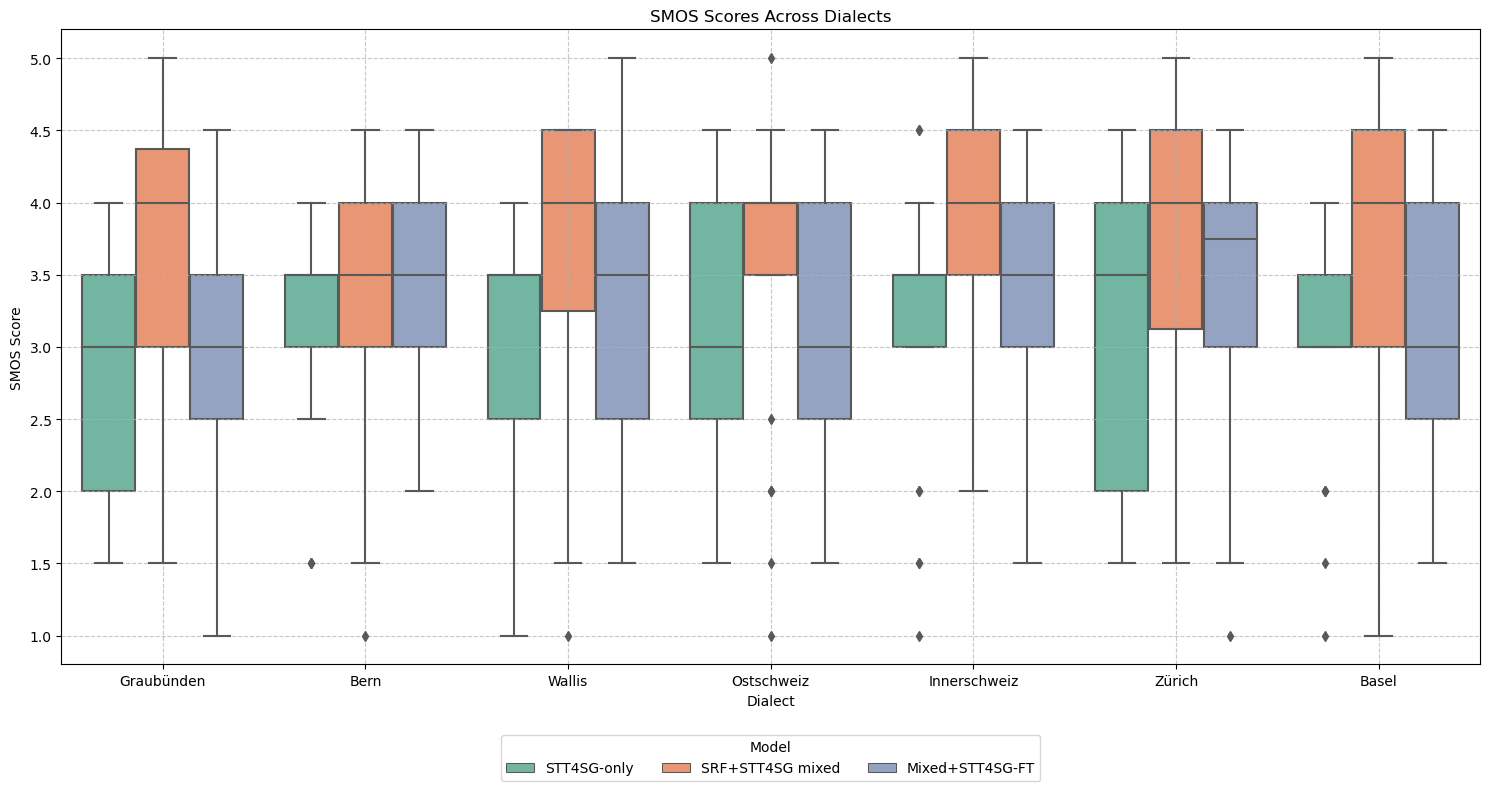

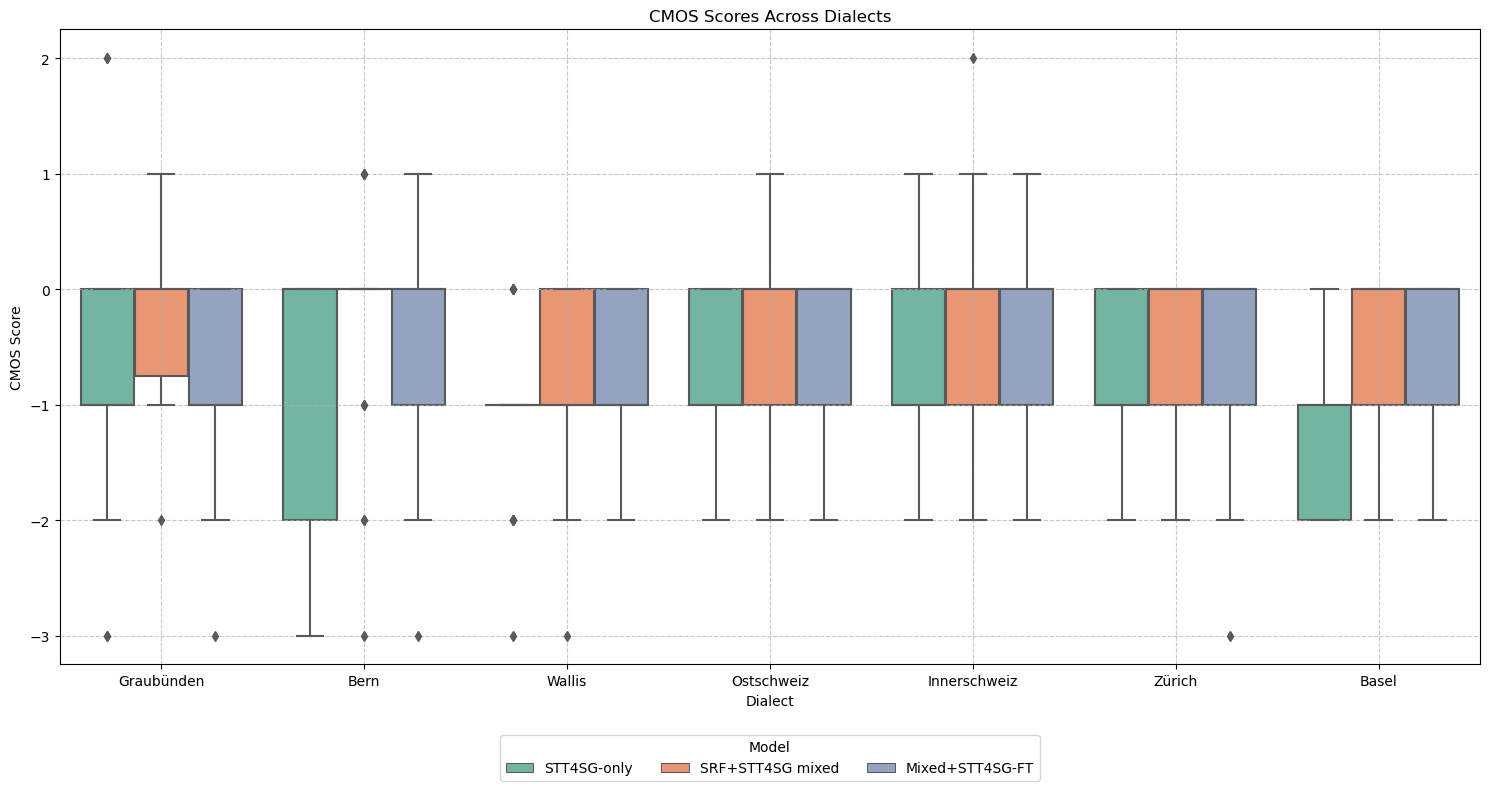

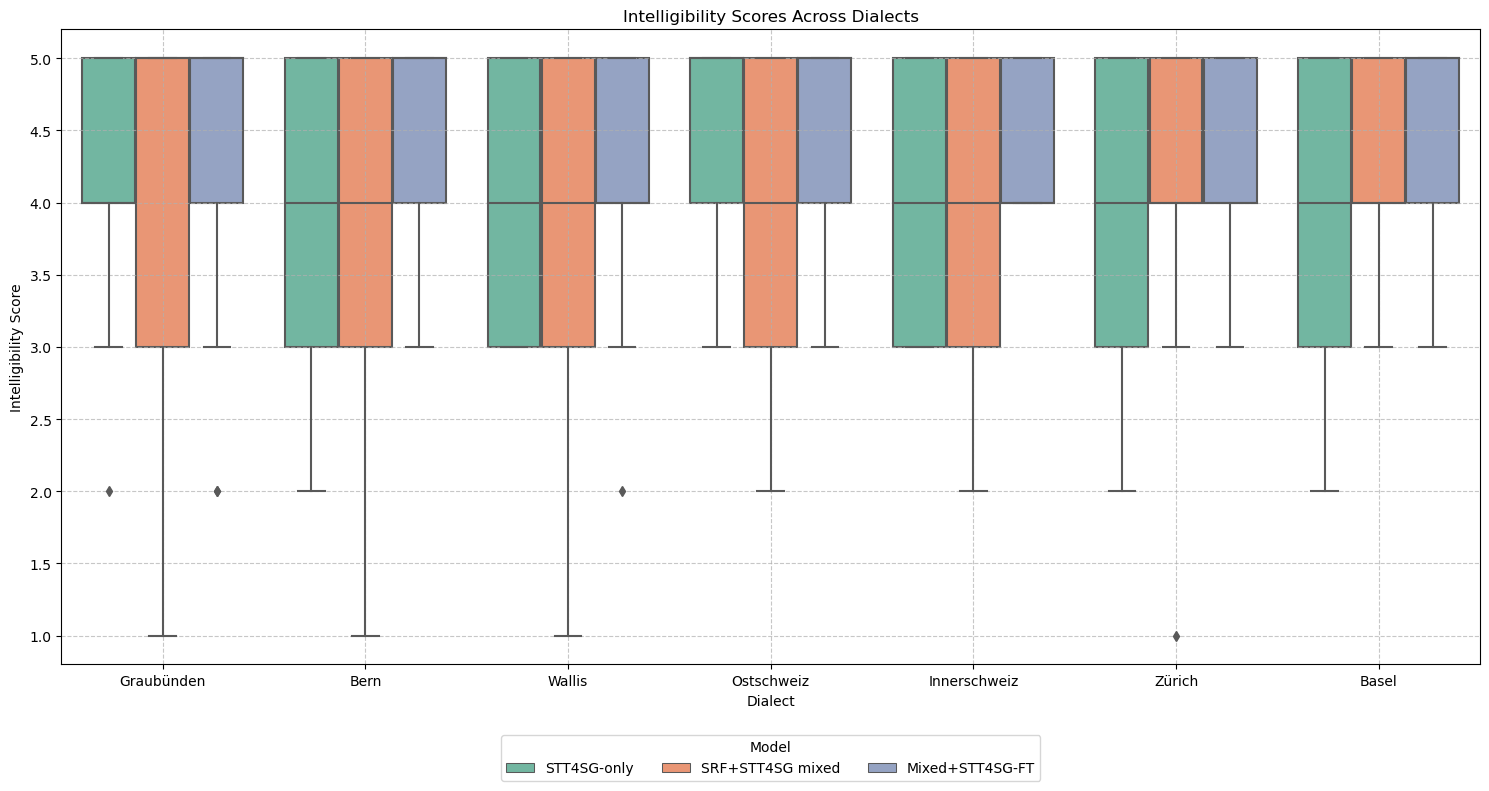

model  orig_dialect  smos        cmos       intelligibility        \
                           mean   std  mean   std            mean   std   
0       7_5         Basel  3.54  1.14 -0.38  0.58            4.29  0.75   
1       7_5          Bern  3.40  0.92 -0.24  0.93            3.80  1.26   
2       7_5    Graubünden  3.67  0.87 -0.19  0.69            3.96  1.37   
3       7_5  Innerschweiz  3.90  0.82 -0.29  0.85            3.95  0.92   
4       7_5    Ostschweiz  3.46  0.97 -0.59  0.89            3.78  1.09   
5       7_5        Wallis  3.54  1.10 -0.78  0.90            3.87  1.29   
6       7_5        Zürich  3.75  1.02 -0.45  0.67            4.23  0.97   
7   7_6_SNF         Basel  3.17  0.92 -0.58  0.72            4.54  0.72   
8   7_6_SNF          Bern  3.36  0.70 -0.36  0.81            4.60  0.58   
9   7_6_SNF    Graubünden  2.92  0.89 -0.88  0.86            4.35  0.94   
10  7_6_SNF  Innerschweiz  3.33  0.94 -0.43  0.81            4.33  0.48   
11  7_6_SNF    Ostschweiz  3.15  0.93 -0.63  0.74            4.52  0.58   
12  7_6_SNF        Wallis  3.22  0.93 -0.74  0.81            4.17  0.78   
13  7_6_SNF        Zürich  3.30  1.08 -0.59  0.80            4.23  0.69   
14      9_2         Basel  3.02  0.79 -1.17  0.70            3.92  1.02   
15      9_2          Bern  3.12  0.75 -0.84  1.03            4.04  0.98   
16      9_2    Graubünden  2.90  0.89 -0.65  1.20            4.19  0.85   
17      9_2  Innerschweiz  3.07  0.97 -0.86  0.85            4.10  0.83   
18      9_2    Ostschweiz  3.15  0.84 -0.78  0.80            4.33  0.78   
19      9_2        Wallis  3.00  0.95 -1.09  0.73            4.04  0.82   
20      9_2        Zürich  3.00  1.05 -0.73  0.77            3.77  1.02   

   support  
            
0       24  
1       25  
2       26  
3       21  
4       27  
5       23  
6       22  
7       24  
8       25  
9       26  
10      21  
11      27  
12      23  
13      22  
14      24  
15      25  
16      26  
17      21  
18      27  
19      23  
20      22

In [212]:
res = group_by_dialect(complete_model)
rename_model = {
   "7_5":"SRF+STT4SG mixed",
   "7_6_SNF":"Mixed+STT4SG-FT",
   "9_2":"STT4SG-only"    
}
# Model names
dialects  = ["Basel", "Bern", "Graubünden", "Innerschweiz", "Ostschweiz", "Wallis", "Zürich"]

complete_model["orig_dialect"] = [dialect.replace("ZÃ¼rich", "Zürich").replace("GraubÃ¼nden", "Graubünden") for dialect in complete_model["orig_dialect"]]
sub_complete_model = complete_model.copy()

sub_complete_model["model"] = [rename_model[model] for model in complete_model["model"]]

# Assuming df is your DataFrame
res = res.reset_index()  # Reset index to get 'model' and 'orig_dialect' as columns
# Define metrics to plot
titles = ["SMOS Scores Across Dialects", "CMOS Scores Across Dialects", "Intelligibility Scores Across Dialects"]
y_labels = ["SMOS Score", "CMOS Score", "Intelligibility Score"]

# Set up the figure with 3 subplots
for metric, title, ylabel in zip(metrics, titles, y_labels):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=sub_complete_model, x="orig_dialect", y=metric, hue="model", palette="Set2")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Dialect")
    plt.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Metrics means and std deviations
# smos_means = res["smos", "mean"]
# smos_std = res["smos", "std"]

# cmos_means = res["cmos", "mean"]
# cmos_std = res["cmos", "std"]

# intelligibility_means = res["intelligibility", "mean"]
# intelligibility_std = res["intelligibility", "std"]

# # Creating the figure and axis
# fig, ax = plt.subplots(figsize=(10, 6))

# # Bar width
# bar_width = 0.2
# index = np.arange(len(dialects))

# # Plotting bars for each metric
# bar1 = ax.bar(index - bar_width, smos_means, bar_width, yerr=smos_std, label='SMOS', capsize=5, color='lightblue')
# bar2 = ax.bar(index, cmos_means, bar_width, yerr=cmos_std, label='CMOS', capsize=5, color='salmon')
# bar3 = ax.bar(index + bar_width, intelligibility_means, bar_width, yerr=intelligibility_std, label='Intelligibility', capsize=5, color='lightgreen')

# # Adding labels and title
# ax.set_xlabel('Models')
# ax.set_ylabel('Scores')
# ax.set_title('Comparison of Dialects based on Metrics')
# ax.set_xticks(index)
# ax.set_xticklabels(dialects, rotation=45, ha="right")
# ax.legend()

res

In [170]:
models

['SRF+STT4SG mixed', 'Mixed+STT4SG-FT', 'STT4SG-only']

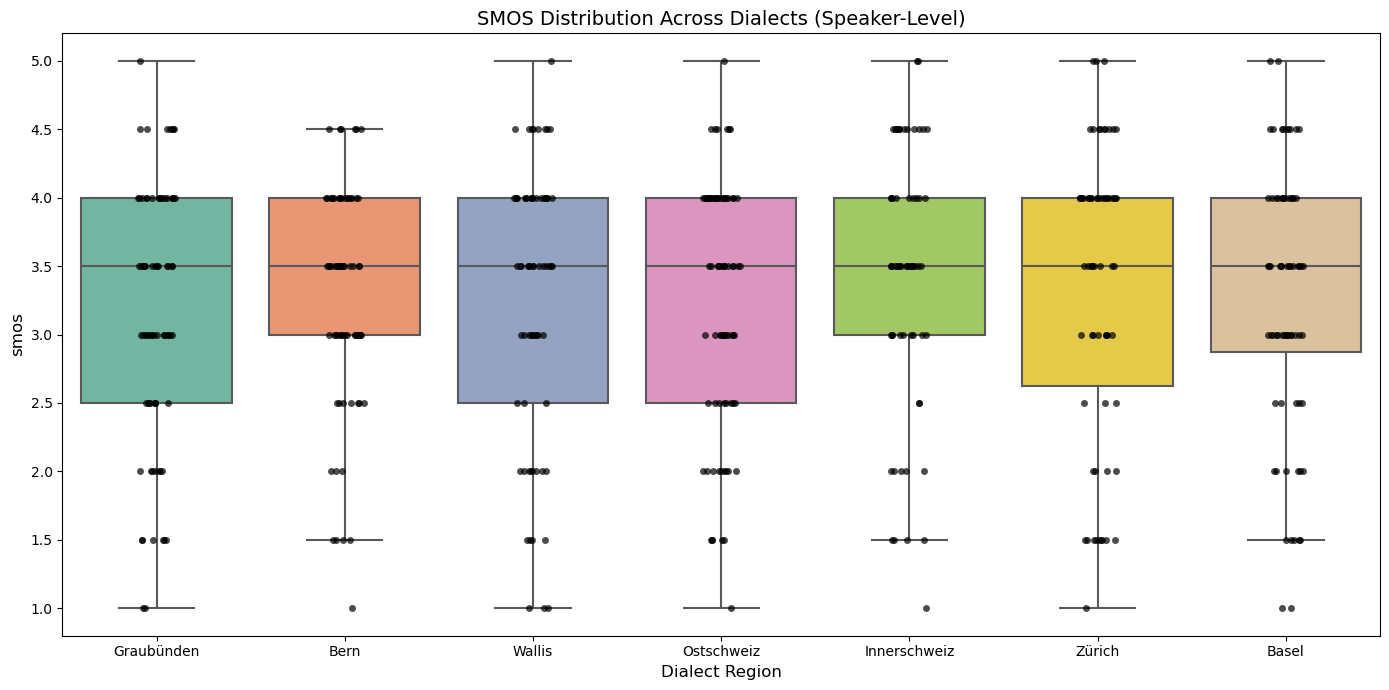

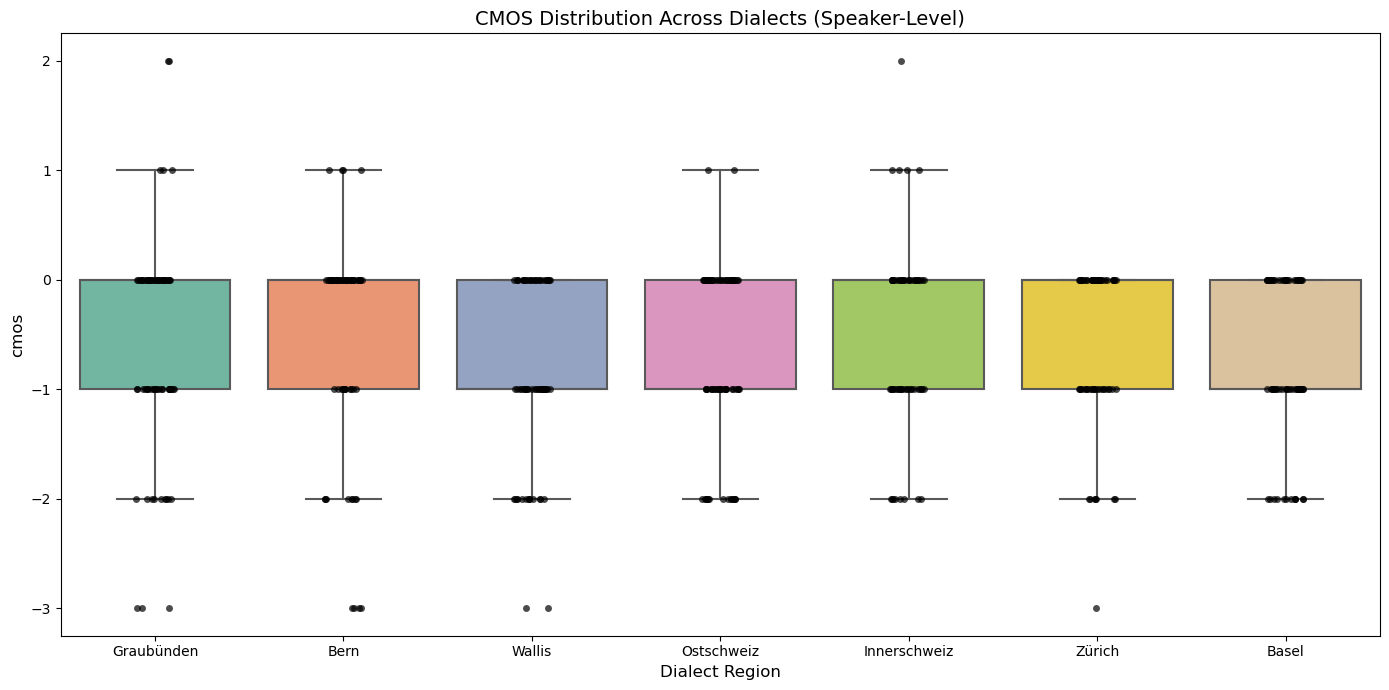

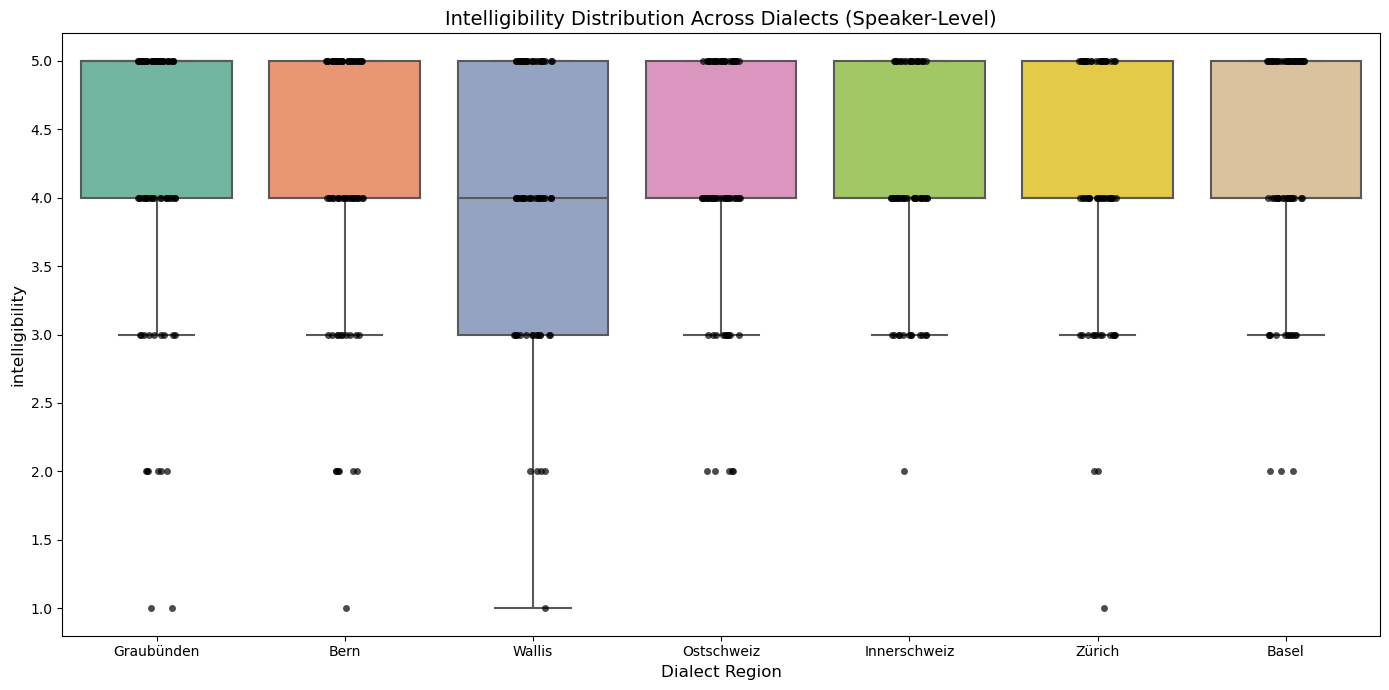

In [215]:
# Define metrics and titles

titles = ["SMOS Distribution Across Dialects (Speaker-Level)", 
          "CMOS Distribution Across Dialects (Speaker-Level)", 
          "Intelligibility Distribution Across Dialects (Speaker-Level)"]

# Create separate plots for each metric
for i, metric in enumerate(metrics):
    plt.figure(figsize=(14, 7))  # Adjust figure size
    
    # Box plot for dialect-level distribution
    ax = sns.boxplot(data=complete_model, x="orig_dialect", y=metric, palette="Set2", showfliers=False)
    
    # Overlay speaker-level data
    sns.stripplot(data=complete_model, x="orig_dialect", y=metric, jitter=True, size=5, color="black", alpha=0.7)
    
    # Customize plot
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Dialect Region", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()